In [53]:
# Initial Setup & Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn.preprocessing import RobustScaler 
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
from sklearn.model_selection import RandomizedSearchCV
from pandas.plotting import lag_plot
import matplotlib.ticker as mticker
import random
import warnings
warnings.filterwarnings('ignore')

In [54]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [55]:
# Load the Dataset (Adjust file path if necessary)
df = pd.read_csv('./data_with_indicators/stock_prices_2minute_with_indicators.csv', parse_dates=['Datetime'])
df.set_index('Datetime', inplace=True)
df.sort_index(inplace=True)
df.head()

Open    High     Low   Close   Volume Ticker  \
Datetime                                                              
2024-12-31 09:00:00  252.14  252.14  252.01  252.01   1123.0   AAPL   
2024-12-31 09:00:00  221.03  221.03  221.00  221.00    588.0   AMZN   
2024-12-31 09:00:00  136.99  137.16  136.97  137.11  17972.0   NVDA   
2024-12-31 09:00:00  414.01  416.38  414.01  414.75  29498.0   TSLA   
2024-12-31 09:02:00  137.18  137.40  137.11  137.27  15133.0   NVDA   

                          EMA12       EMA26       MACD    Signal  ...  \
Datetime                                                          ...   
2024-12-31 09:00:00  252.010000  252.010000   0.000000  0.000000  ...   
2024-12-31 09:00:00  262.147404  266.798218  -4.650814 -1.558348  ...   
2024-12-31 09:00:00  160.585968  162.723328  -2.137360 -0.419032  ...   
2024-12-31 09:00:00  158.742332  134.607084  24.135247  4.797317  ...   
2024-12-31 09:02:00  156.998896  160.837896  -3.839000 -1.103026  ...   

                     STOCHS_Sell        +DI        -DI         ADX  ADX_Buy  \
Datetime                                                                      
2024-12-31 09:00:00        False        NaN        NaN         NaN    False   
2024-12-31 09:00:00        False  61.212857 -61.212857  133.566327     True   
2024-12-31 09:00:00        False   5.910714  -5.910714    8.011837    False   
2024-12-31 09:00:00        False  27.642857 -27.642857   21.598163    False   
2024-12-31 09:02:00        False   6.696429  -6.696429    8.366020    False   

                     ADX_Sell  Aroon_Up  Aroon_Down  Aroon_Buy  Aroon_Sell  
Datetime                                                                    
2024-12-31 09:00:00     False       NaN         NaN      False       False  
2024-12-31 09:00:00     False       0.0        96.0      False        True  
2024-12-31 09:00:00      True      88.0        96.0      False        True  
2024-12-31 09:00:00      True      96.0         8.0       True       False  
2024-12-31 09:02:00      True      84.0        92.0      False        True  

[5 rows x 47 columns]

In [56]:
# Faceted EDA with enhanced styling
stocks = ["AAPL", "MSFT", "GOOGL", "NVDA", "TSLA", "AMZN", "META"]
colors = ['tab:gray', 'tab:purple', 'tab:olive','tab:green', 'tab:red', 'tab:orange', 'tab:blue']

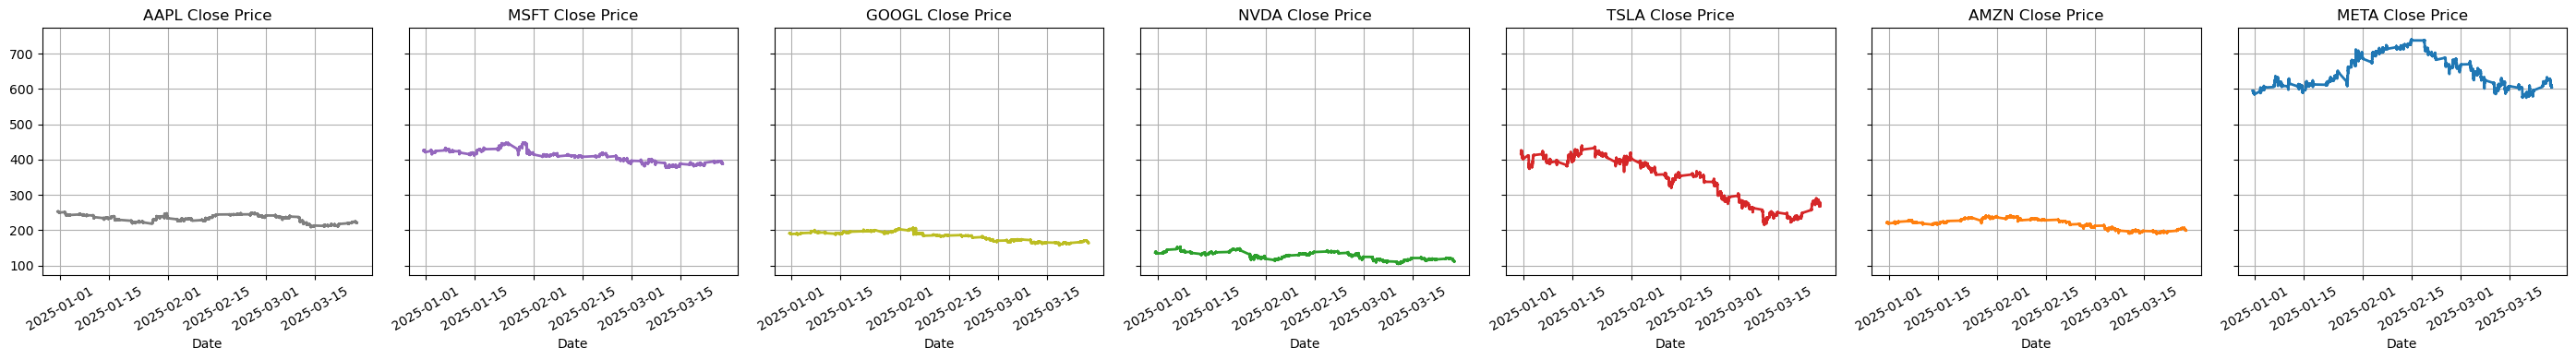

In [57]:
# Close Price Trends Facet (7 columns)
fig, axes = plt.subplots(1, 7, figsize=(28, 4), sharey=True)
for ax, stock, color in zip(axes, stocks, colors):
    df_stock = df[df['Ticker'] == stock]
    ax.plot(df_stock.index, df_stock['Close'], color=color, linewidth=2)
    ax.set_title(f'{stock} Close Price')
    ax.set_xlabel('Date')
    for label in ax.get_xticklabels():
        label.set_rotation(30)
    ax.grid(True)
plt.tight_layout()
plt.show()

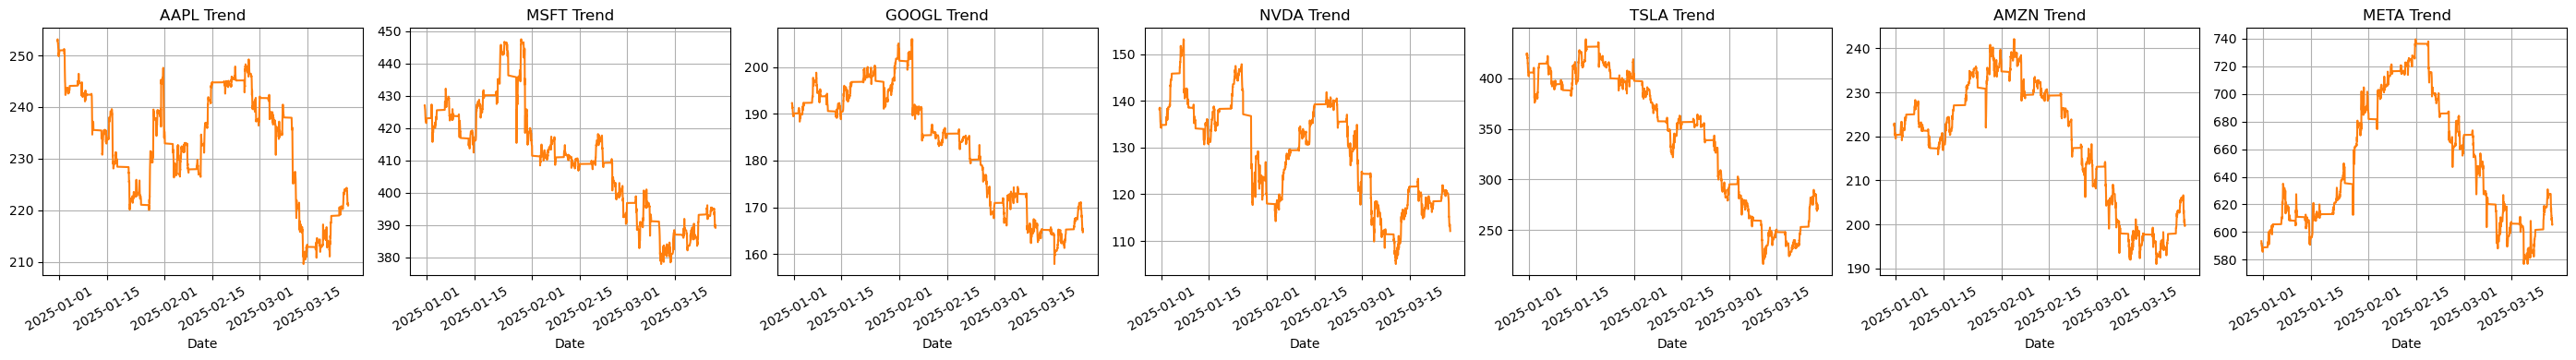

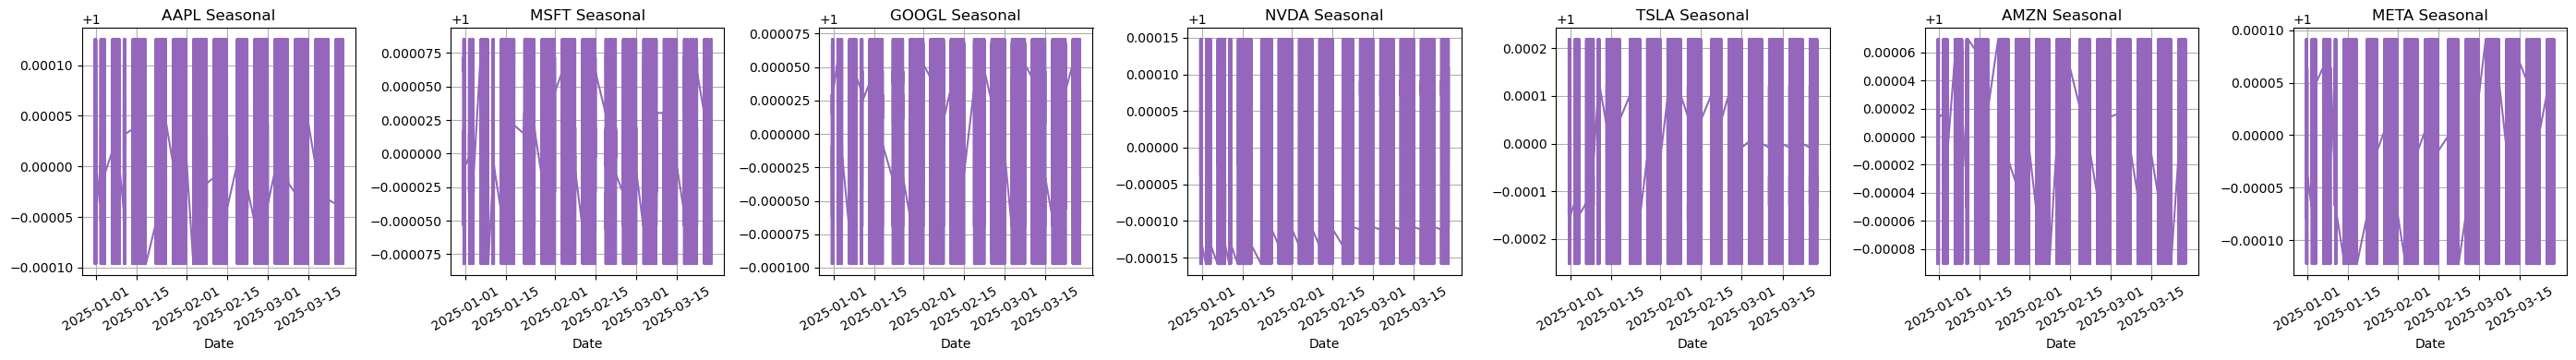

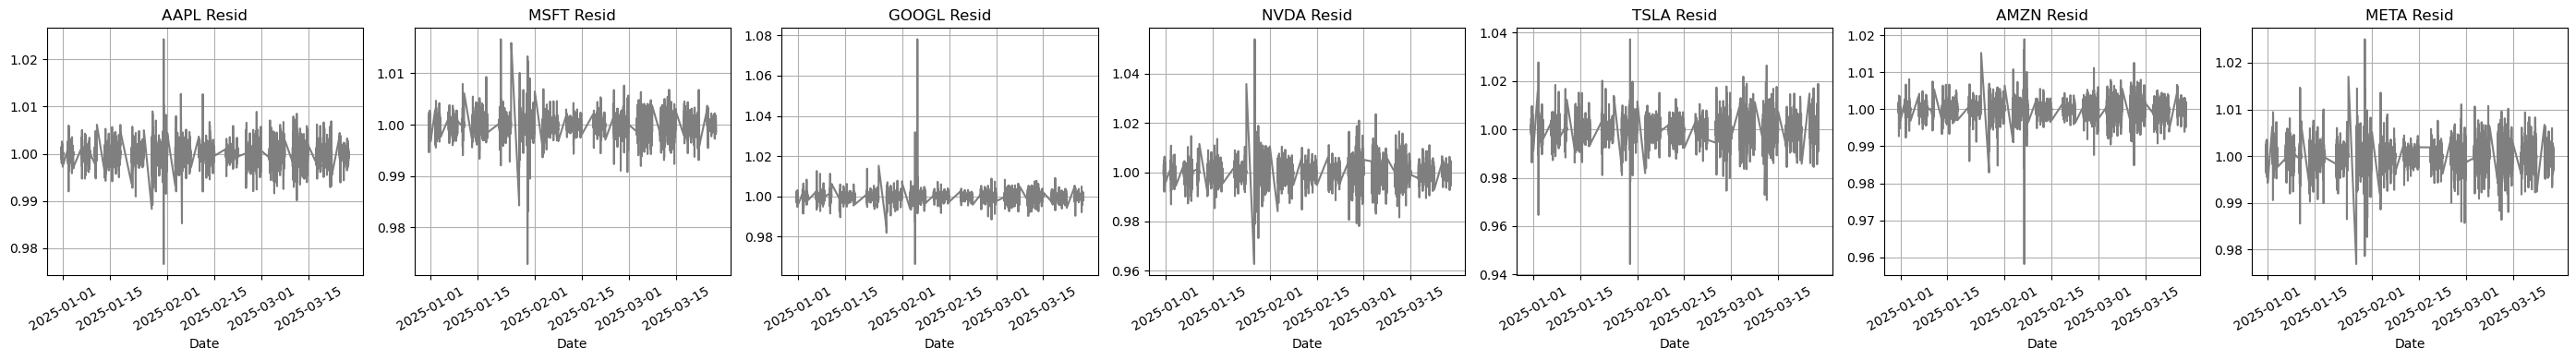

In [58]:
# Seasonal Decomposition Facet (7 columns — one row per component across all stocks)
component_colors = {'trend': 'tab:orange', 'seasonal': 'tab:purple', 'resid': 'tab:gray'}
for comp, comp_color in component_colors.items():
    fig, axes = plt.subplots(1, 7, figsize=(28, 4))
    for ax, stock, color in zip(axes, stocks, colors):
        df_stock = df[df['Ticker'] == stock]
        result = seasonal_decompose(df_stock['Close'], model='multiplicative', period=30)
        comp_series = getattr(result, comp)
        ax.plot(comp_series.index, comp_series, color=comp_color)
        ax.set_title(f'{stock} {comp.capitalize()}')
        ax.set_xlabel('Date')
        for label in ax.get_xticklabels():
            label.set_rotation(30)
        ax.grid(True)
    plt.tight_layout()
    plt.show()

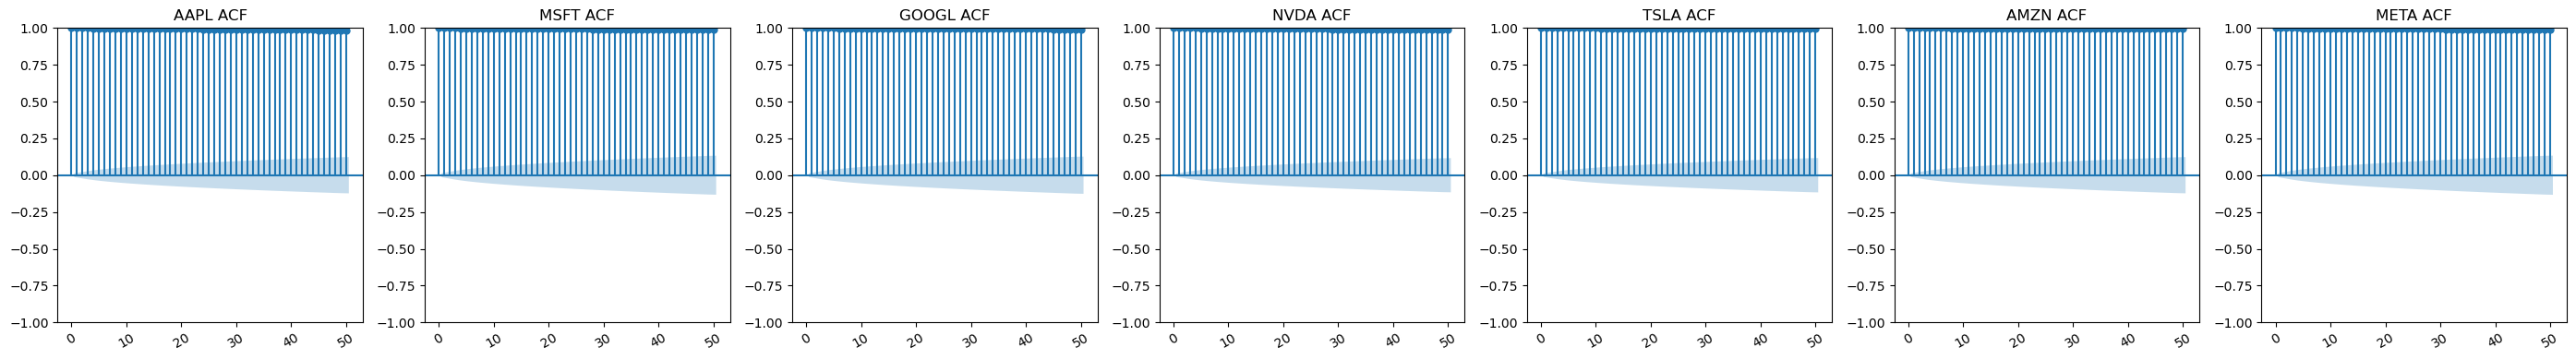

In [59]:
# Standard ACF Facet (7 columns)
fig, axes = plt.subplots(1, 7, figsize=(28, 4))
for ax, stock in zip(axes, stocks):
    df_stock = df[df['Ticker'] == stock]
    plot_acf(df_stock['Close'].dropna(), lags=50, ax=ax)
    ax.set_title(f'{stock} ACF')
    for label in ax.get_xticklabels():
        label.set_rotation(30)
plt.tight_layout()
plt.show()

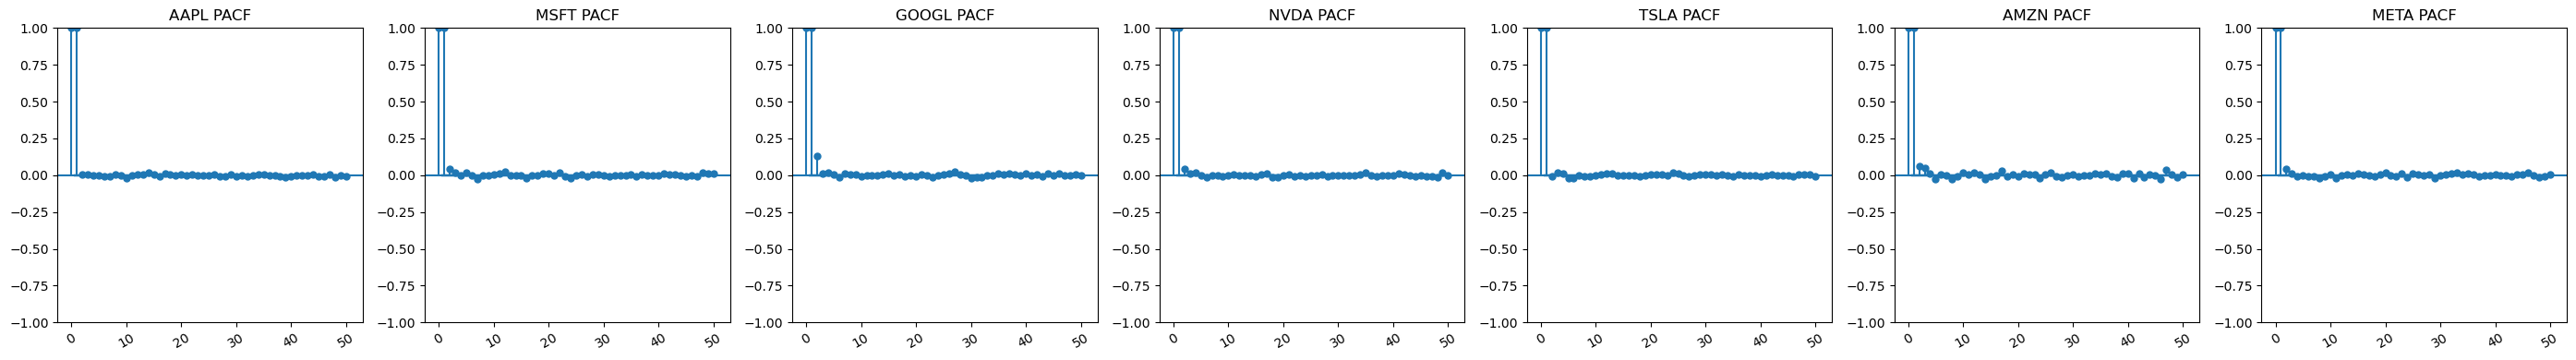

In [60]:
# Standard PACF Facet (7 columns)
fig, axes = plt.subplots(1, 7, figsize=(28, 4))
for ax, stock in zip(axes, stocks):
    df_stock = df[df['Ticker'] == stock]
    plot_pacf(df_stock['Close'].dropna(), lags=50, ax=ax)
    ax.set_title(f'{stock} PACF')
    for label in ax.get_xticklabels():
        label.set_rotation(30)
plt.tight_layout()
plt.show()

In [61]:
# Stationarity Tests
for stock in stocks:
    df_stock = df[df['Ticker'] == stock]
    adf_result = adfuller(df_stock['Close'].dropna())
    print(f'ADF Statistic for {stock}: {adf_result[0]:.4f}, p-value: {adf_result[1]:.4f}')
    if adf_result[1] < 0.05:
        print(f"{stock} series is likely stationary.")
    else:
        print(f"{stock} series is likely non-stationary.")

ADF Statistic for AAPL: -2.0159, p-value: 0.2797
AAPL series is likely non-stationary.
ADF Statistic for MSFT: -1.4380, p-value: 0.5639
MSFT series is likely non-stationary.
ADF Statistic for GOOGL: -0.8415, p-value: 0.8066
GOOGL series is likely non-stationary.
ADF Statistic for NVDA: -1.5492, p-value: 0.5090
NVDA series is likely non-stationary.
ADF Statistic for TSLA: -0.9584, p-value: 0.7681
TSLA series is likely non-stationary.
ADF Statistic for AMZN: -0.8557, p-value: 0.8022
AMZN series is likely non-stationary.
ADF Statistic for META: -1.4410, p-value: 0.5625
META series is likely non-stationary.


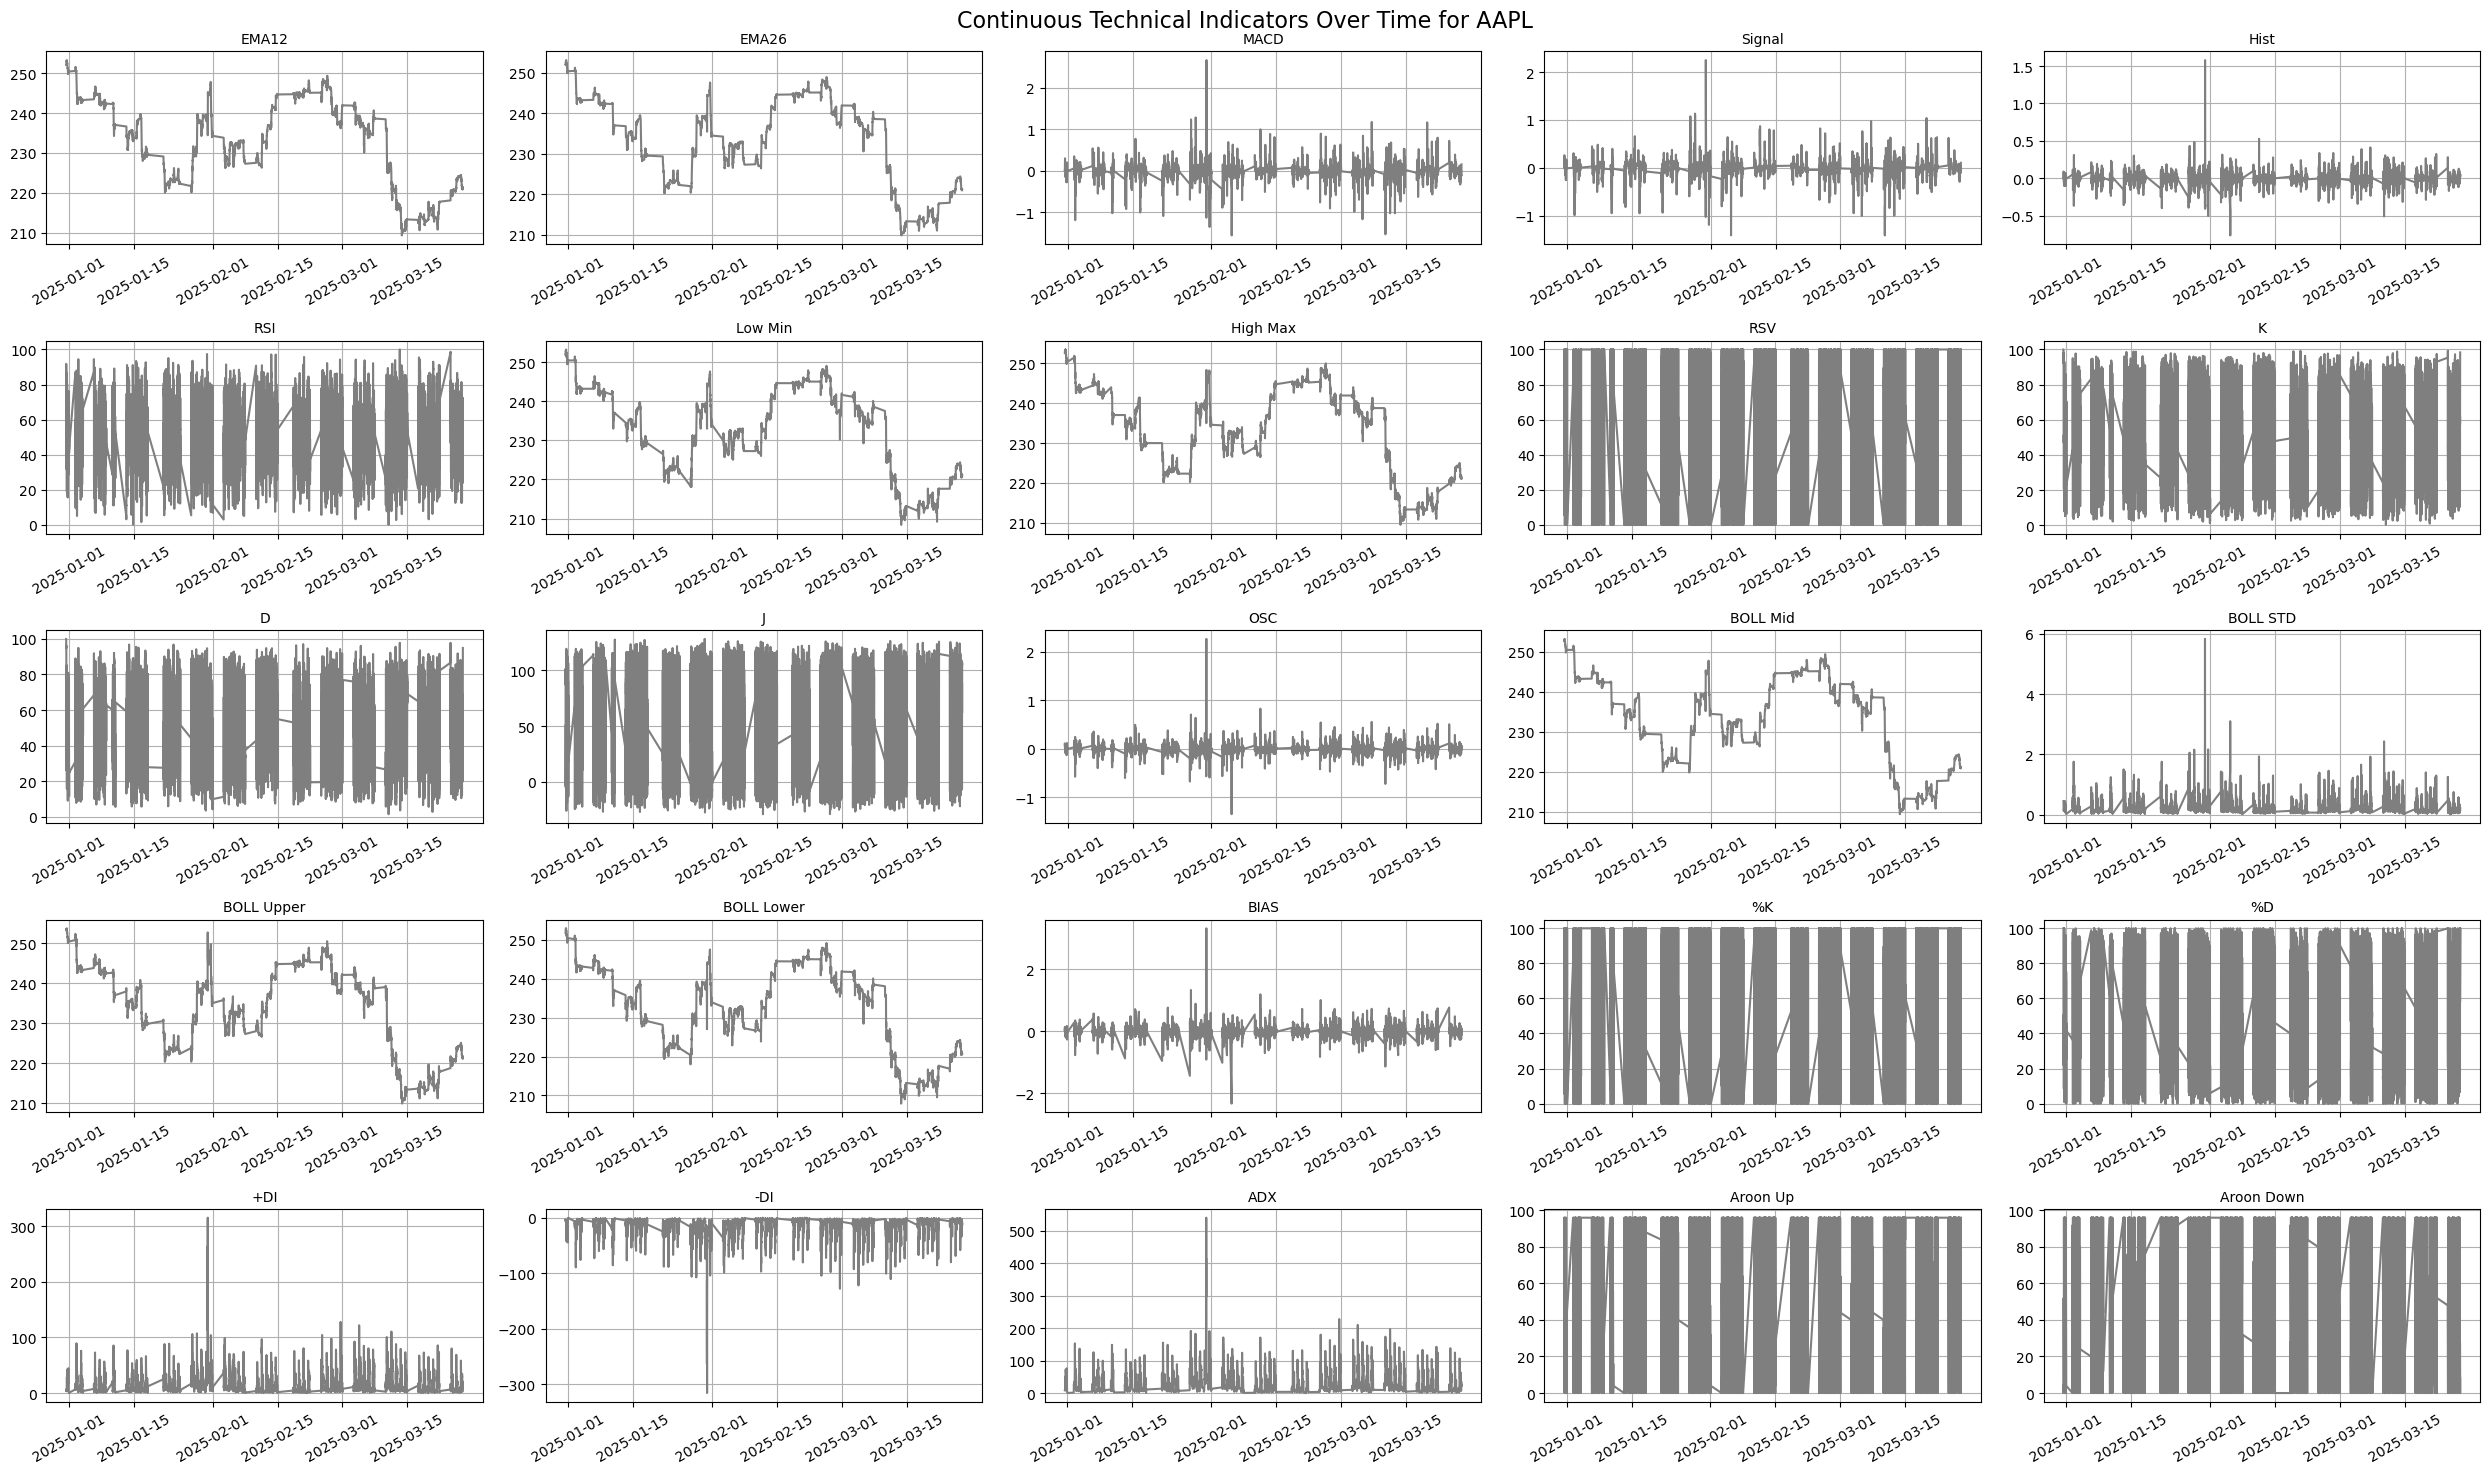

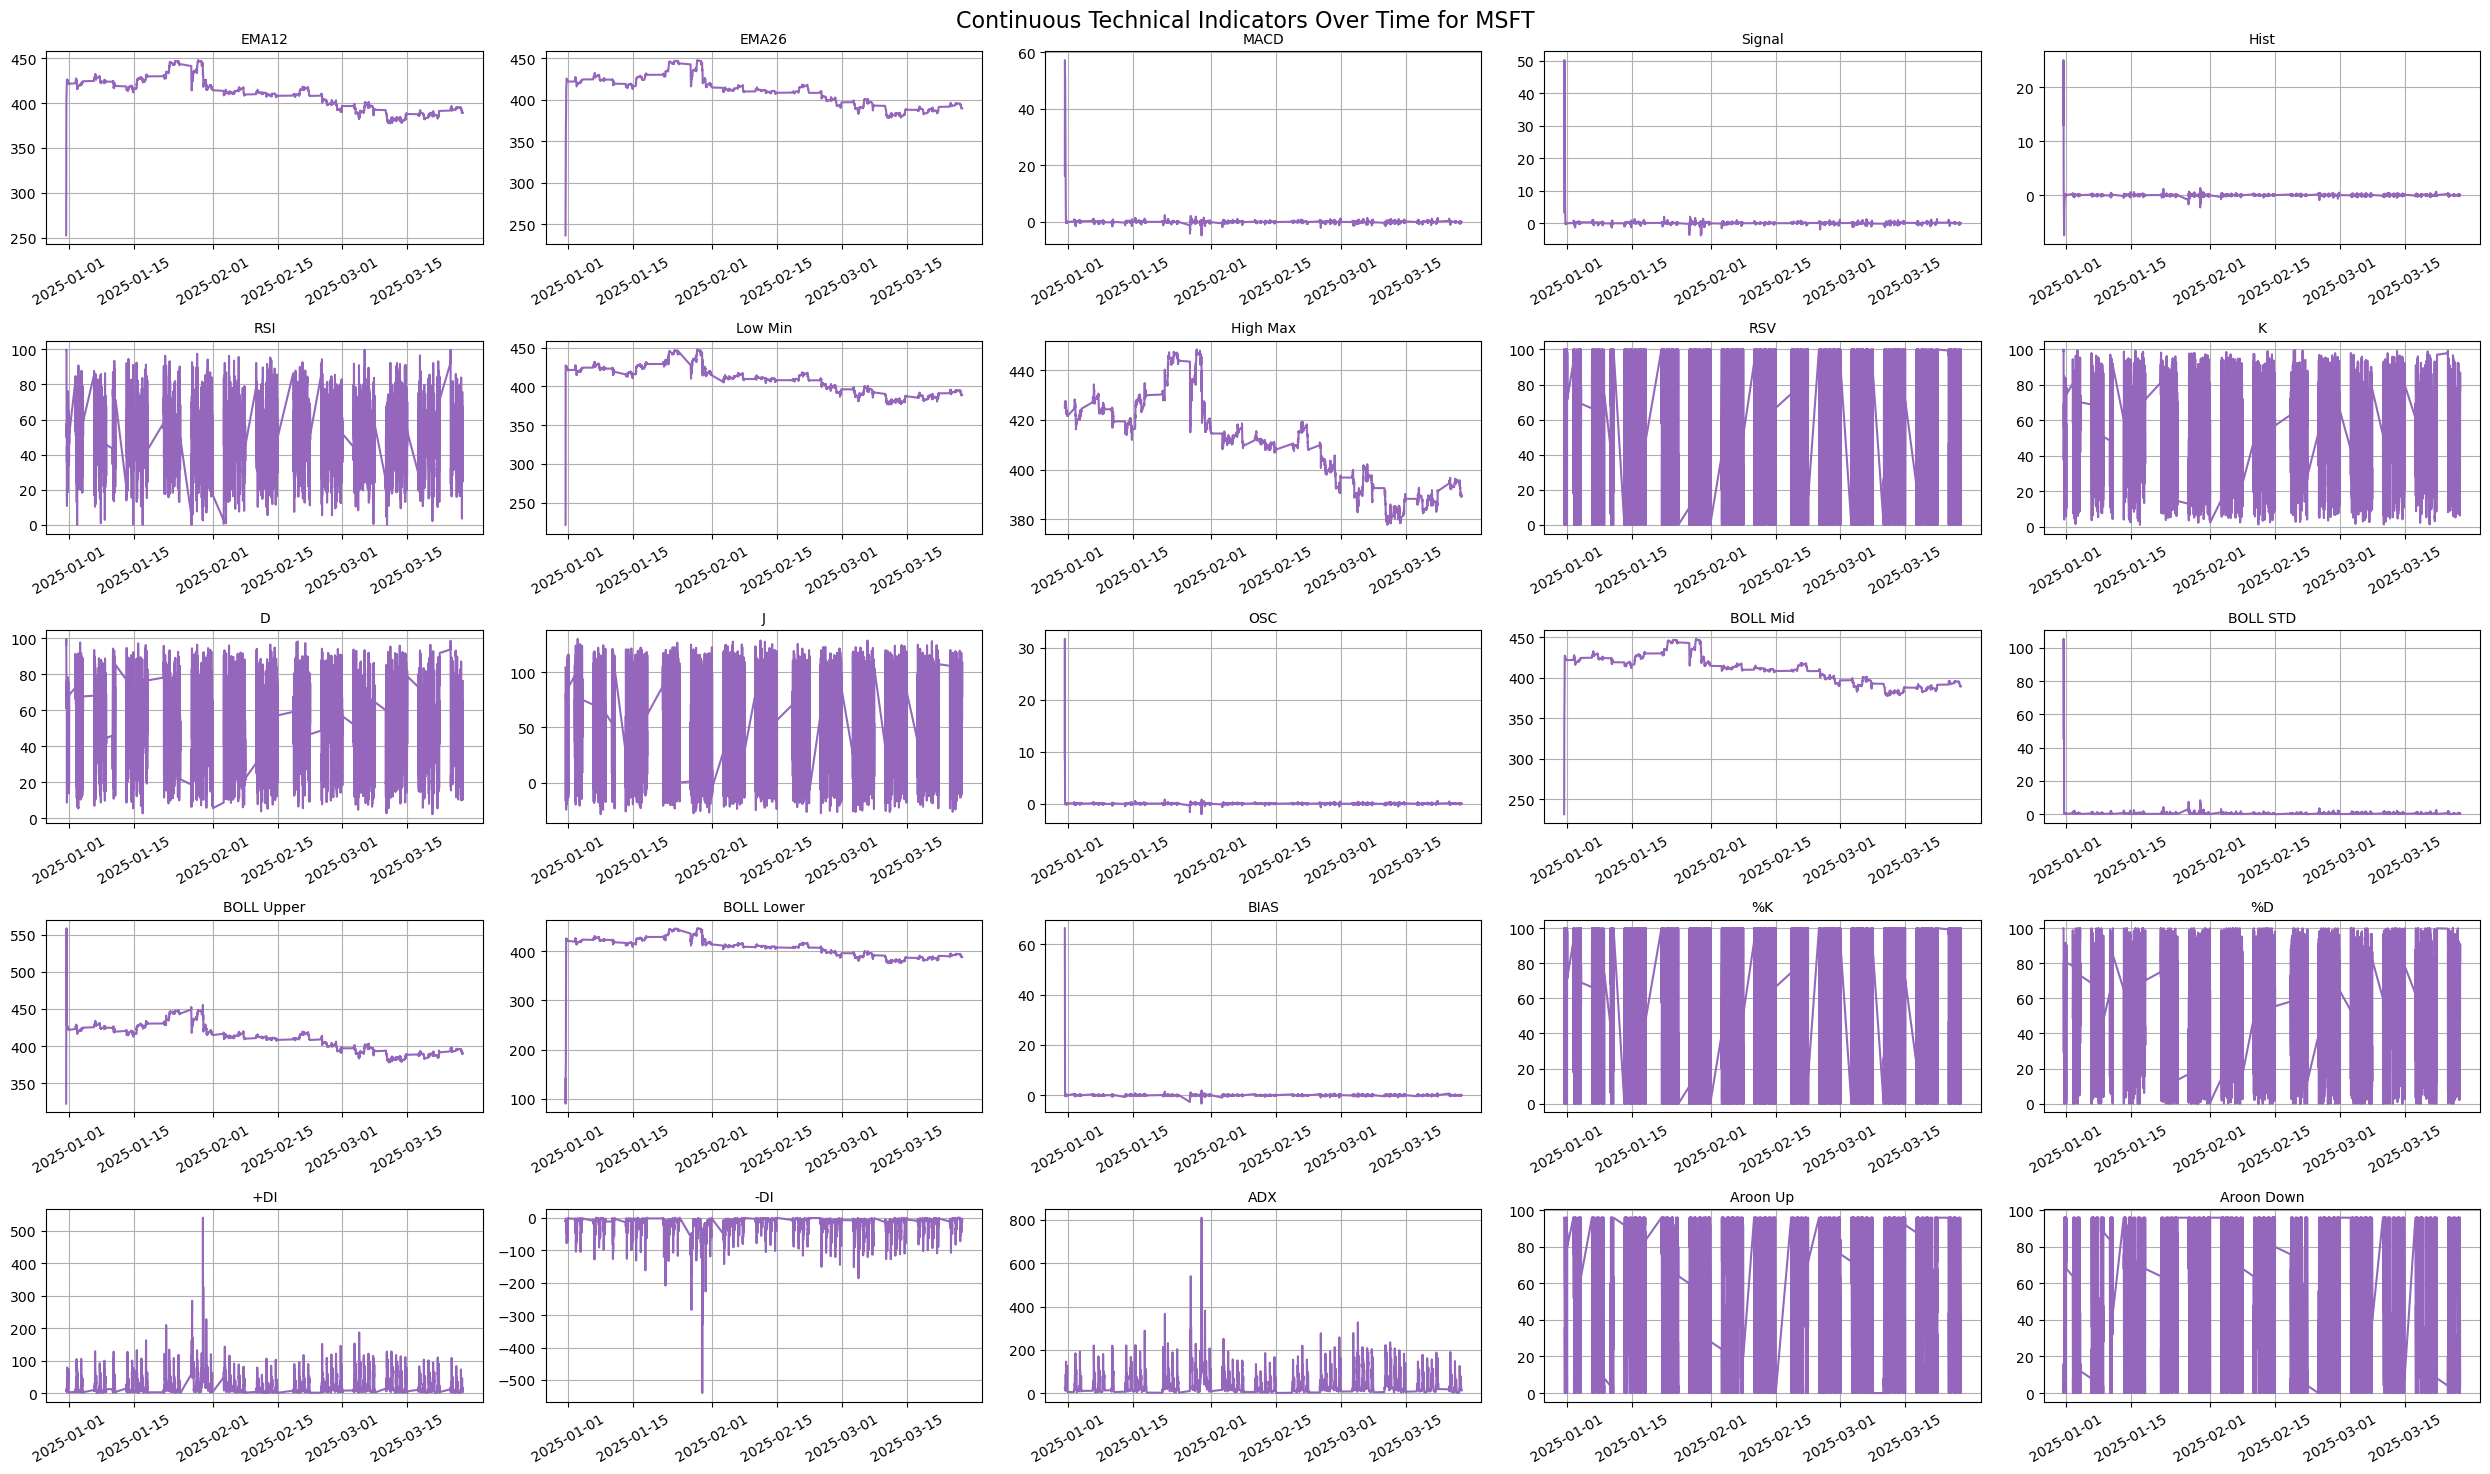

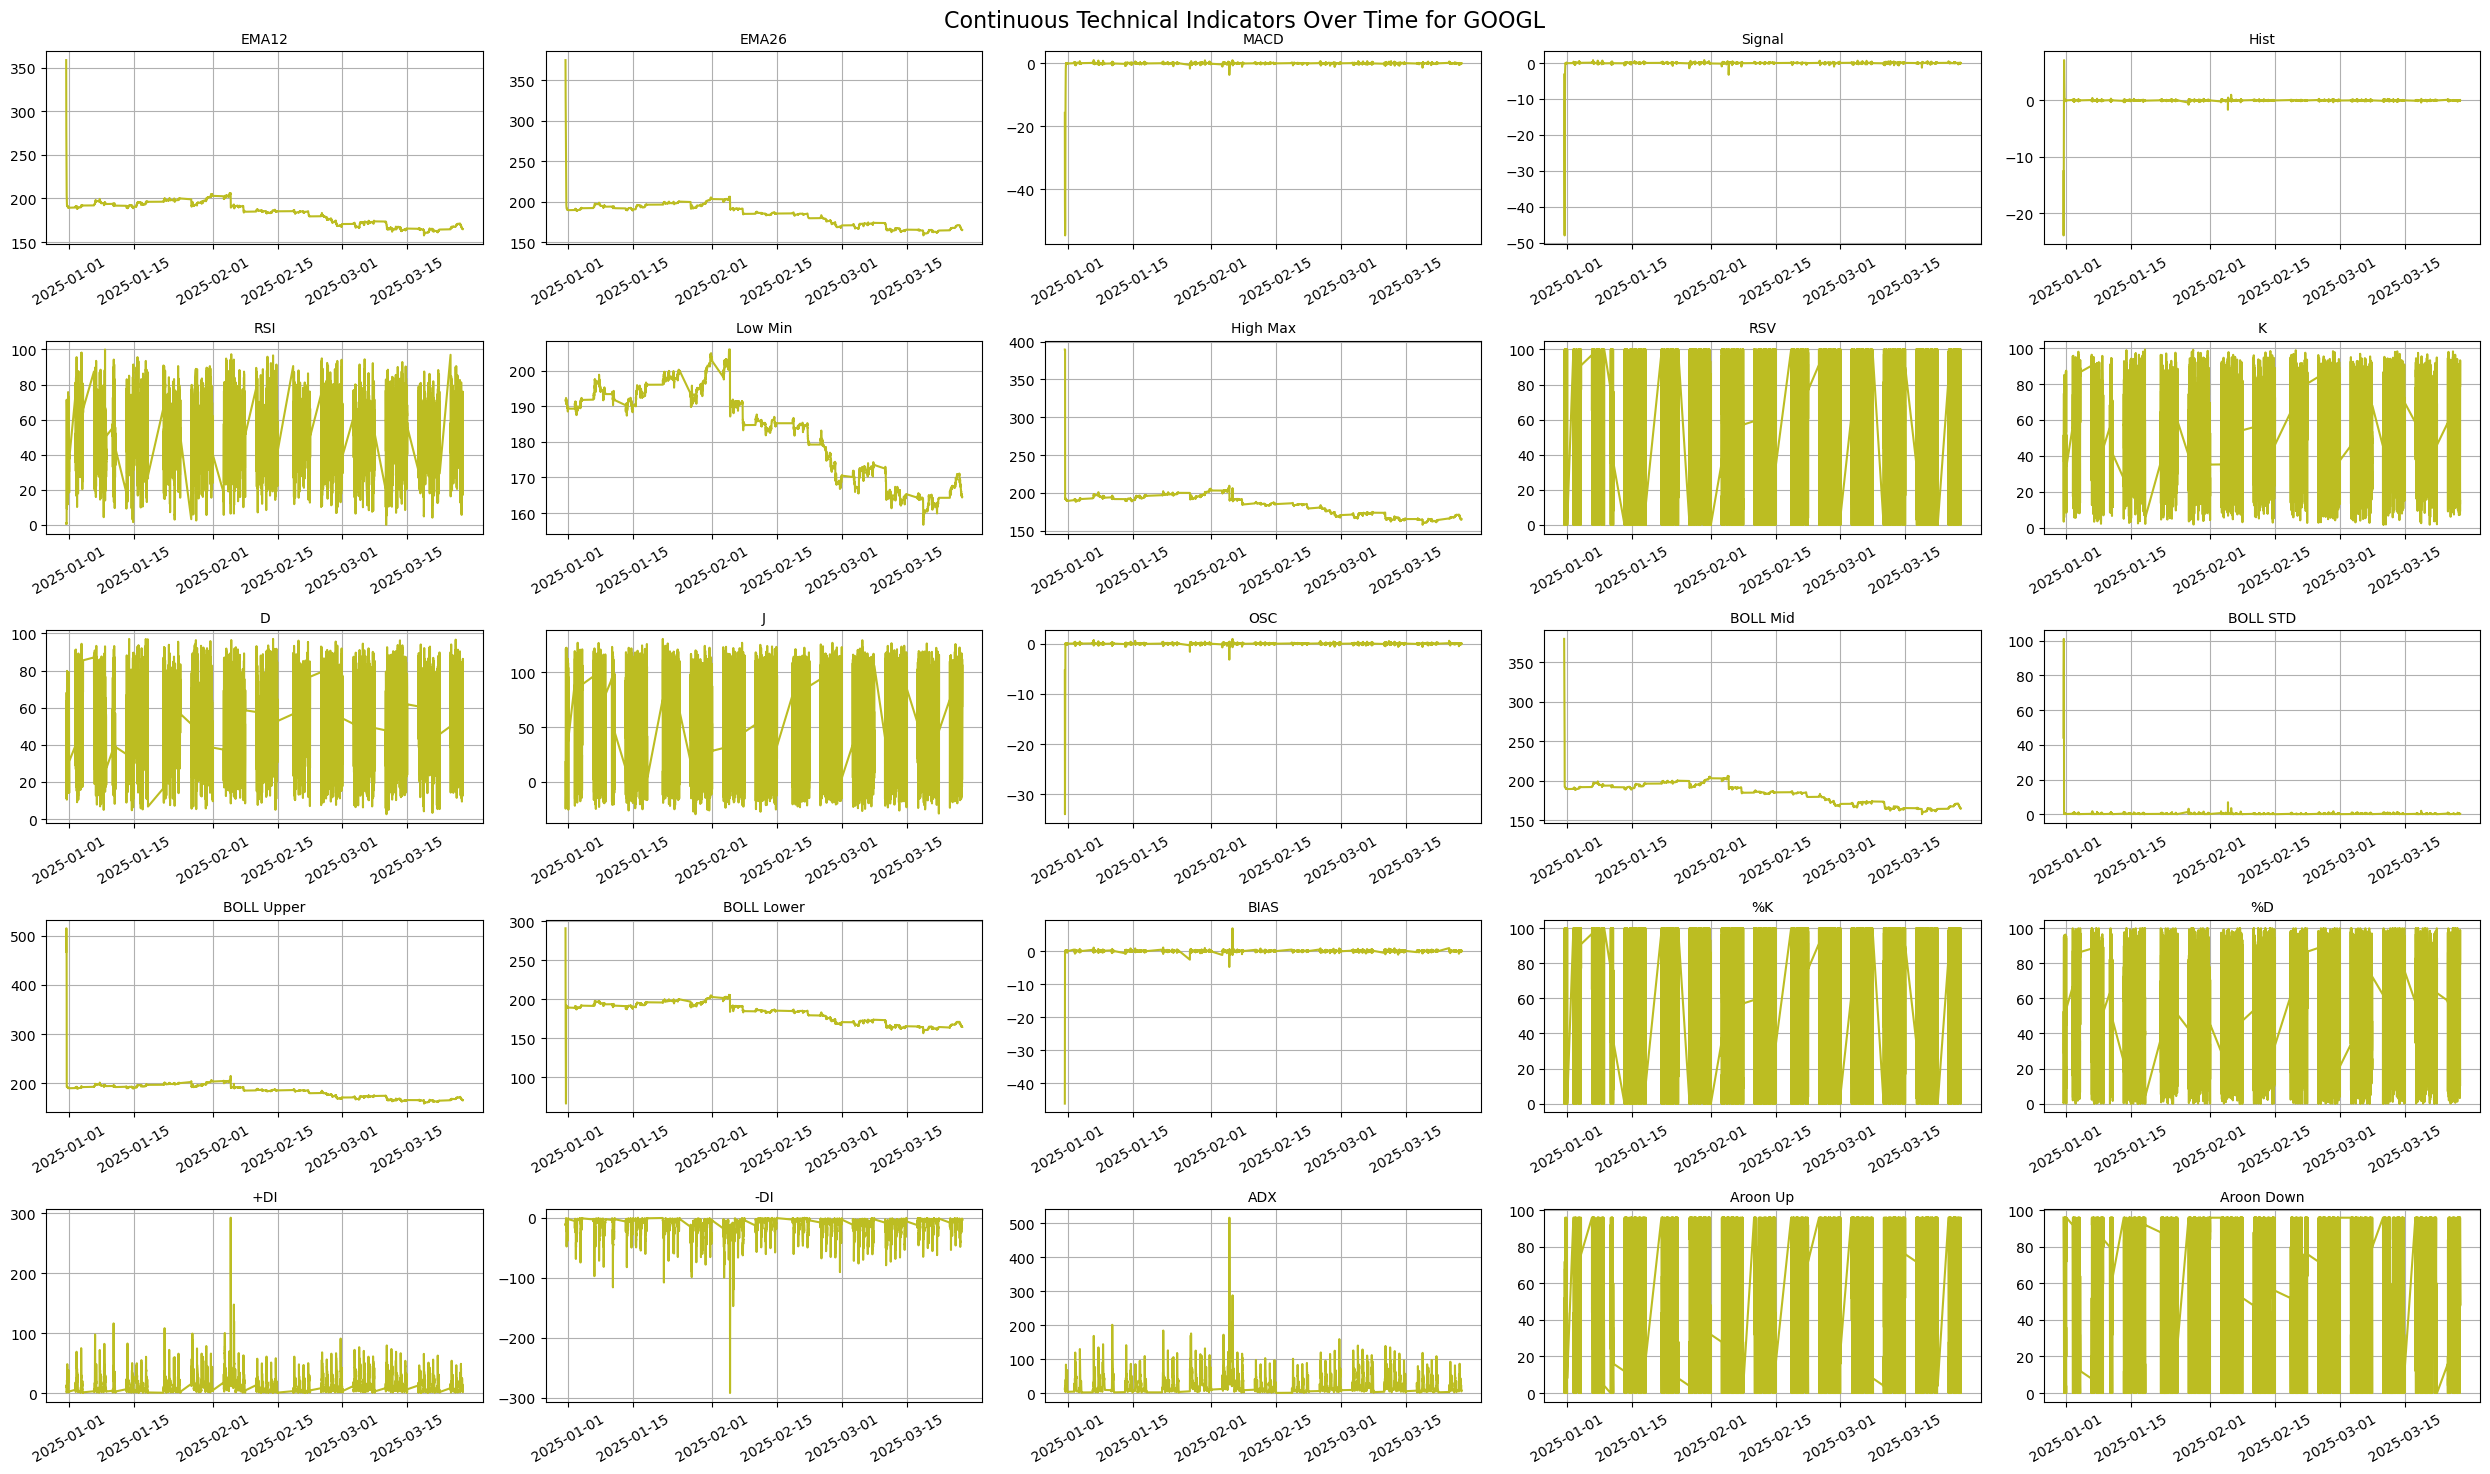

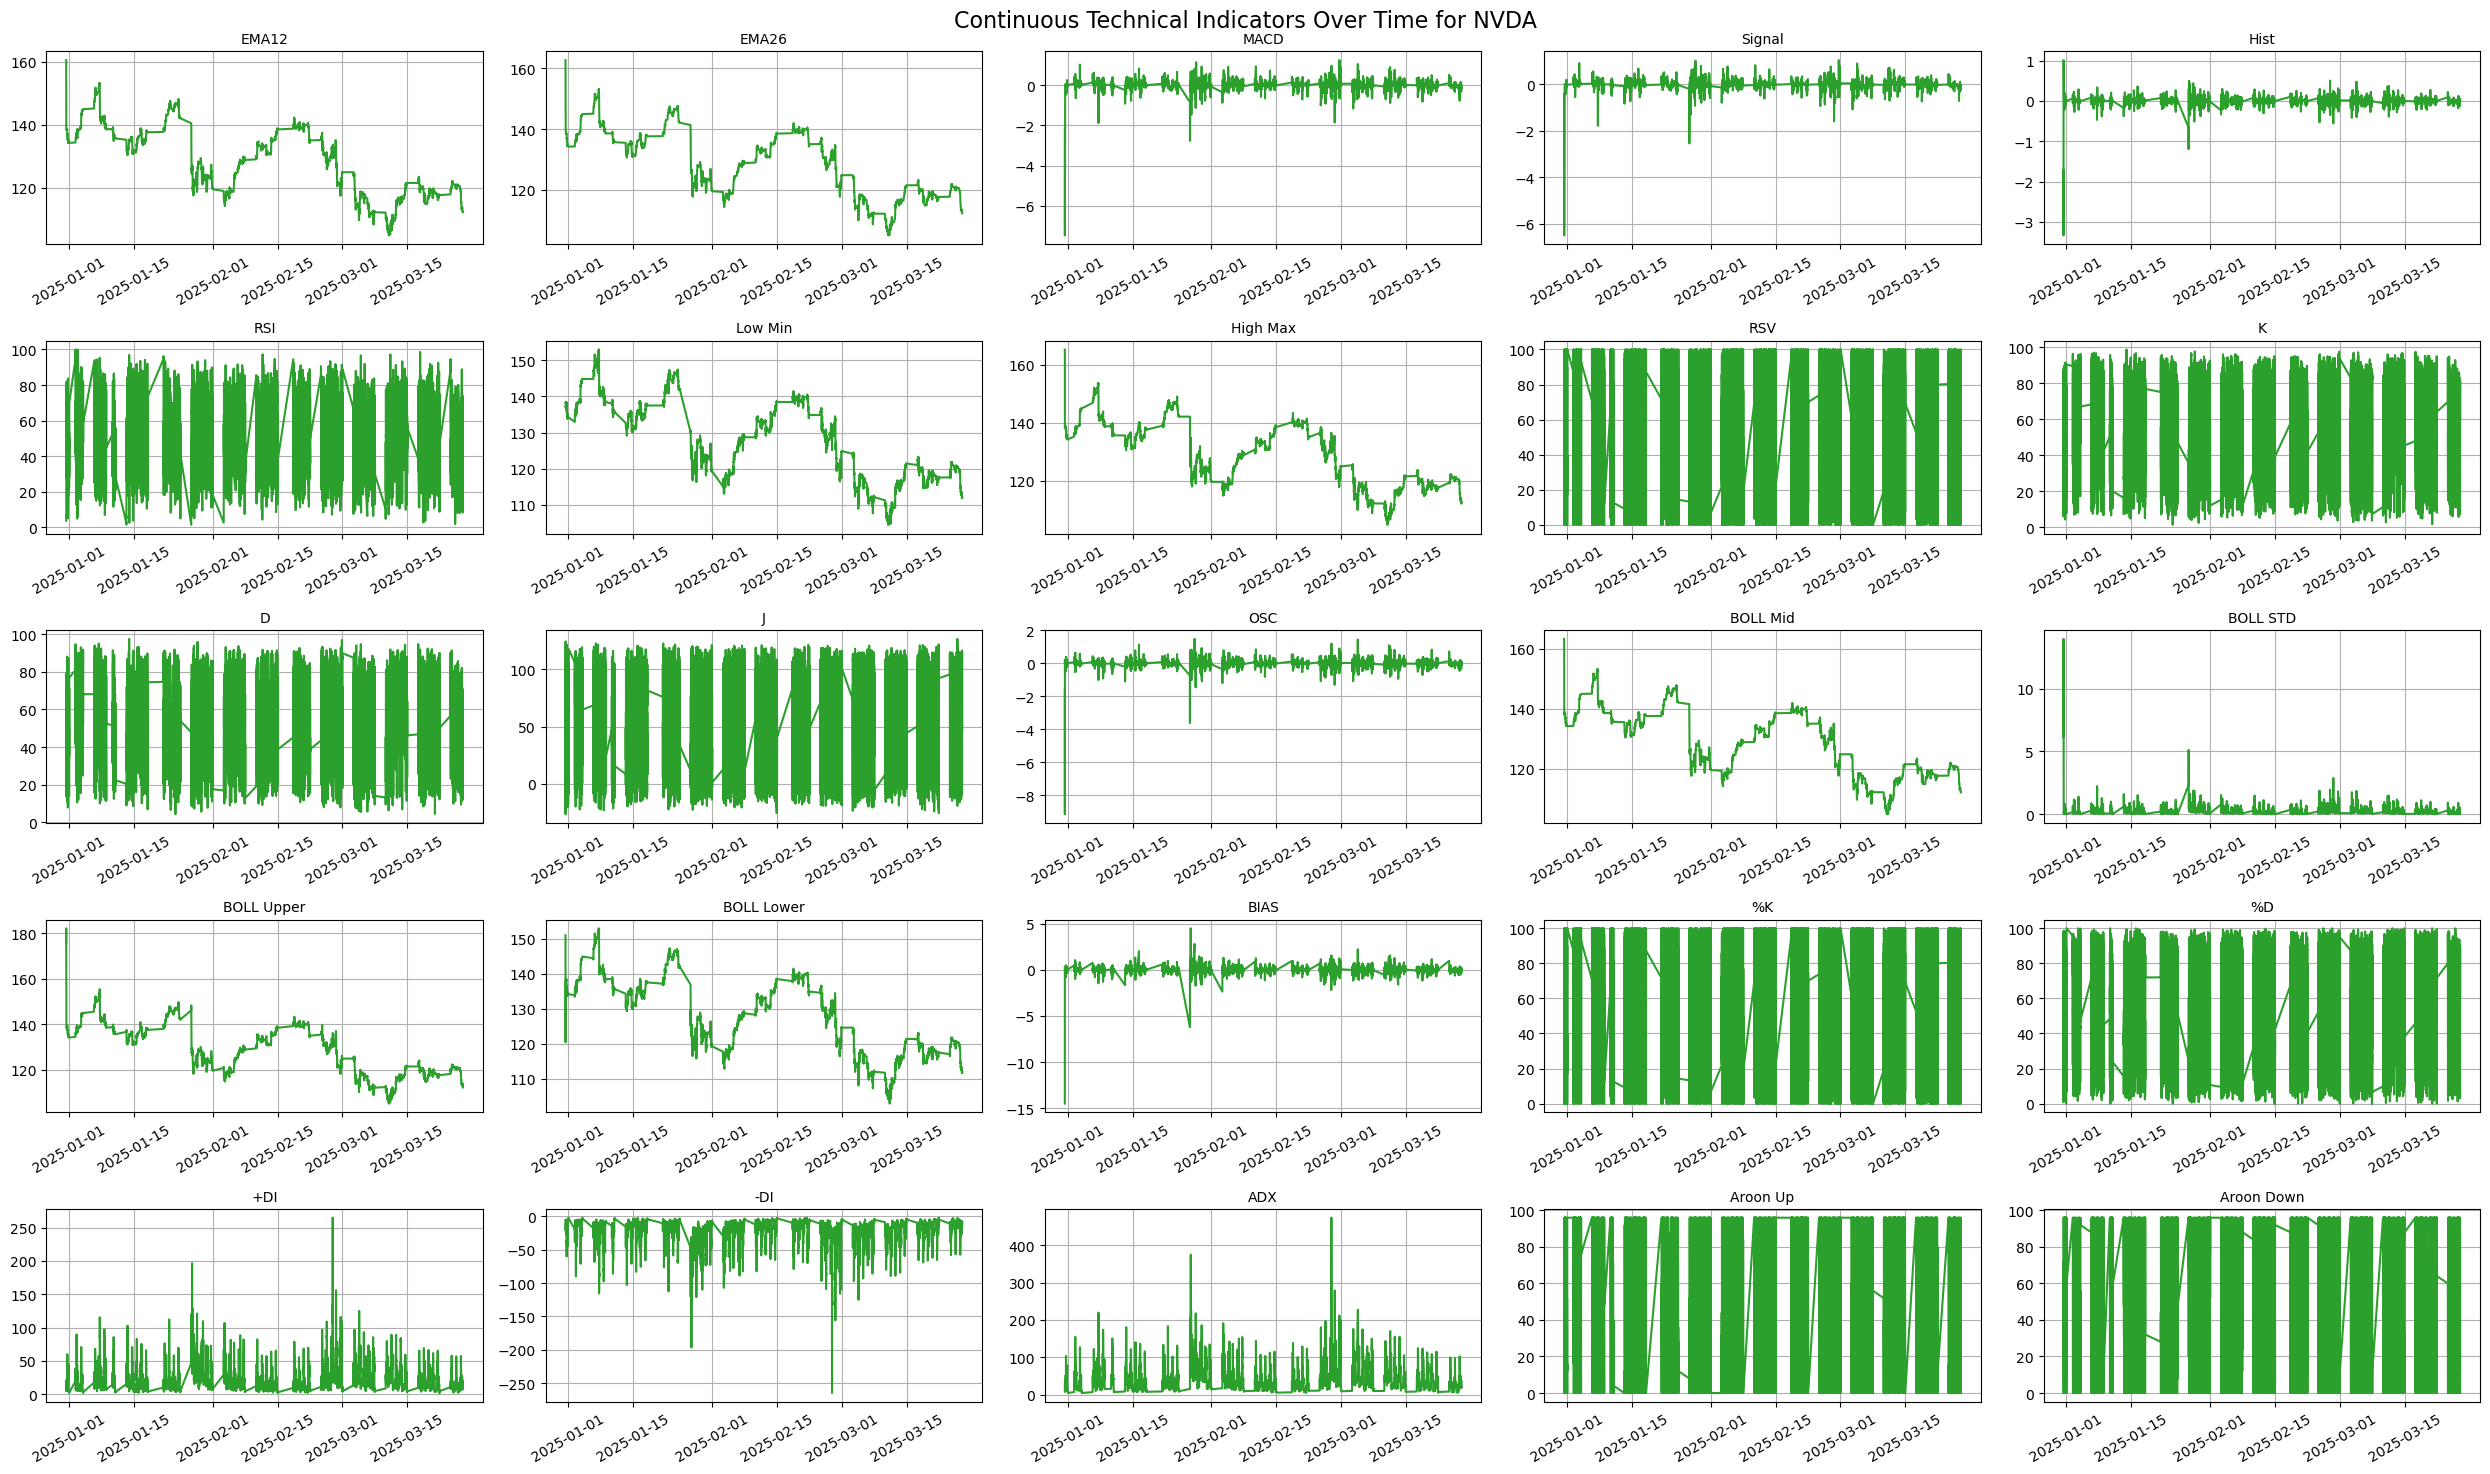

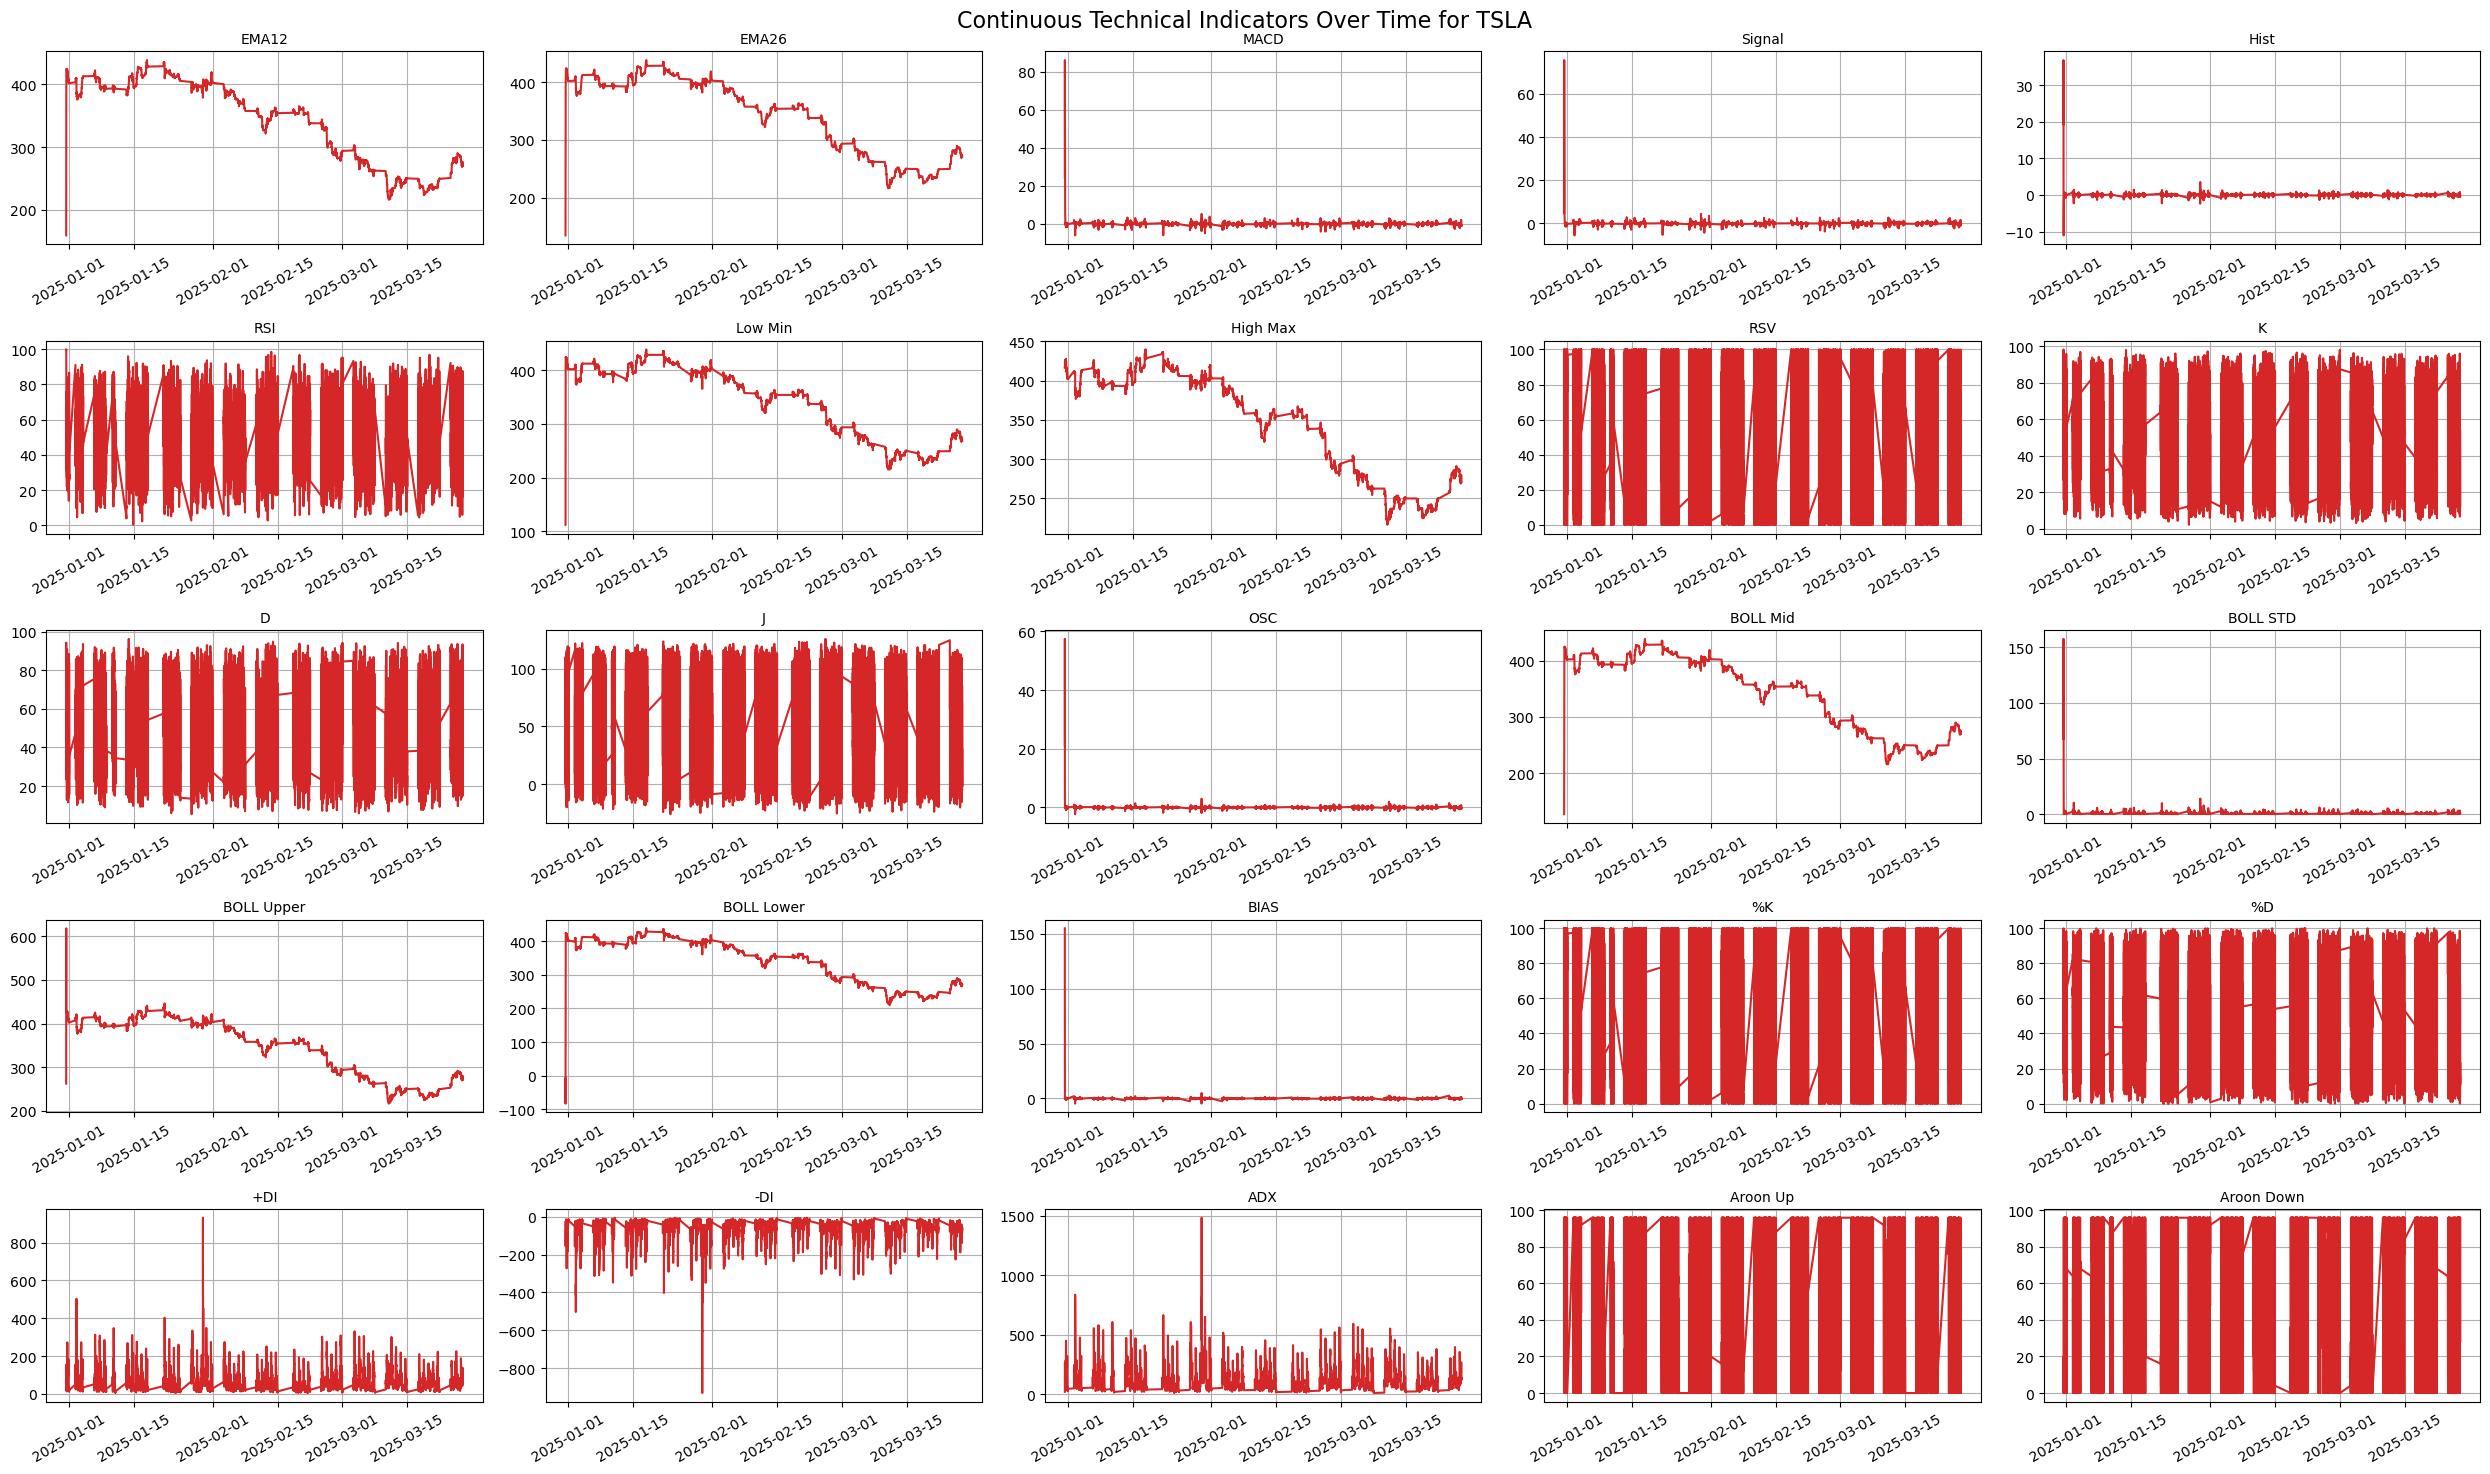

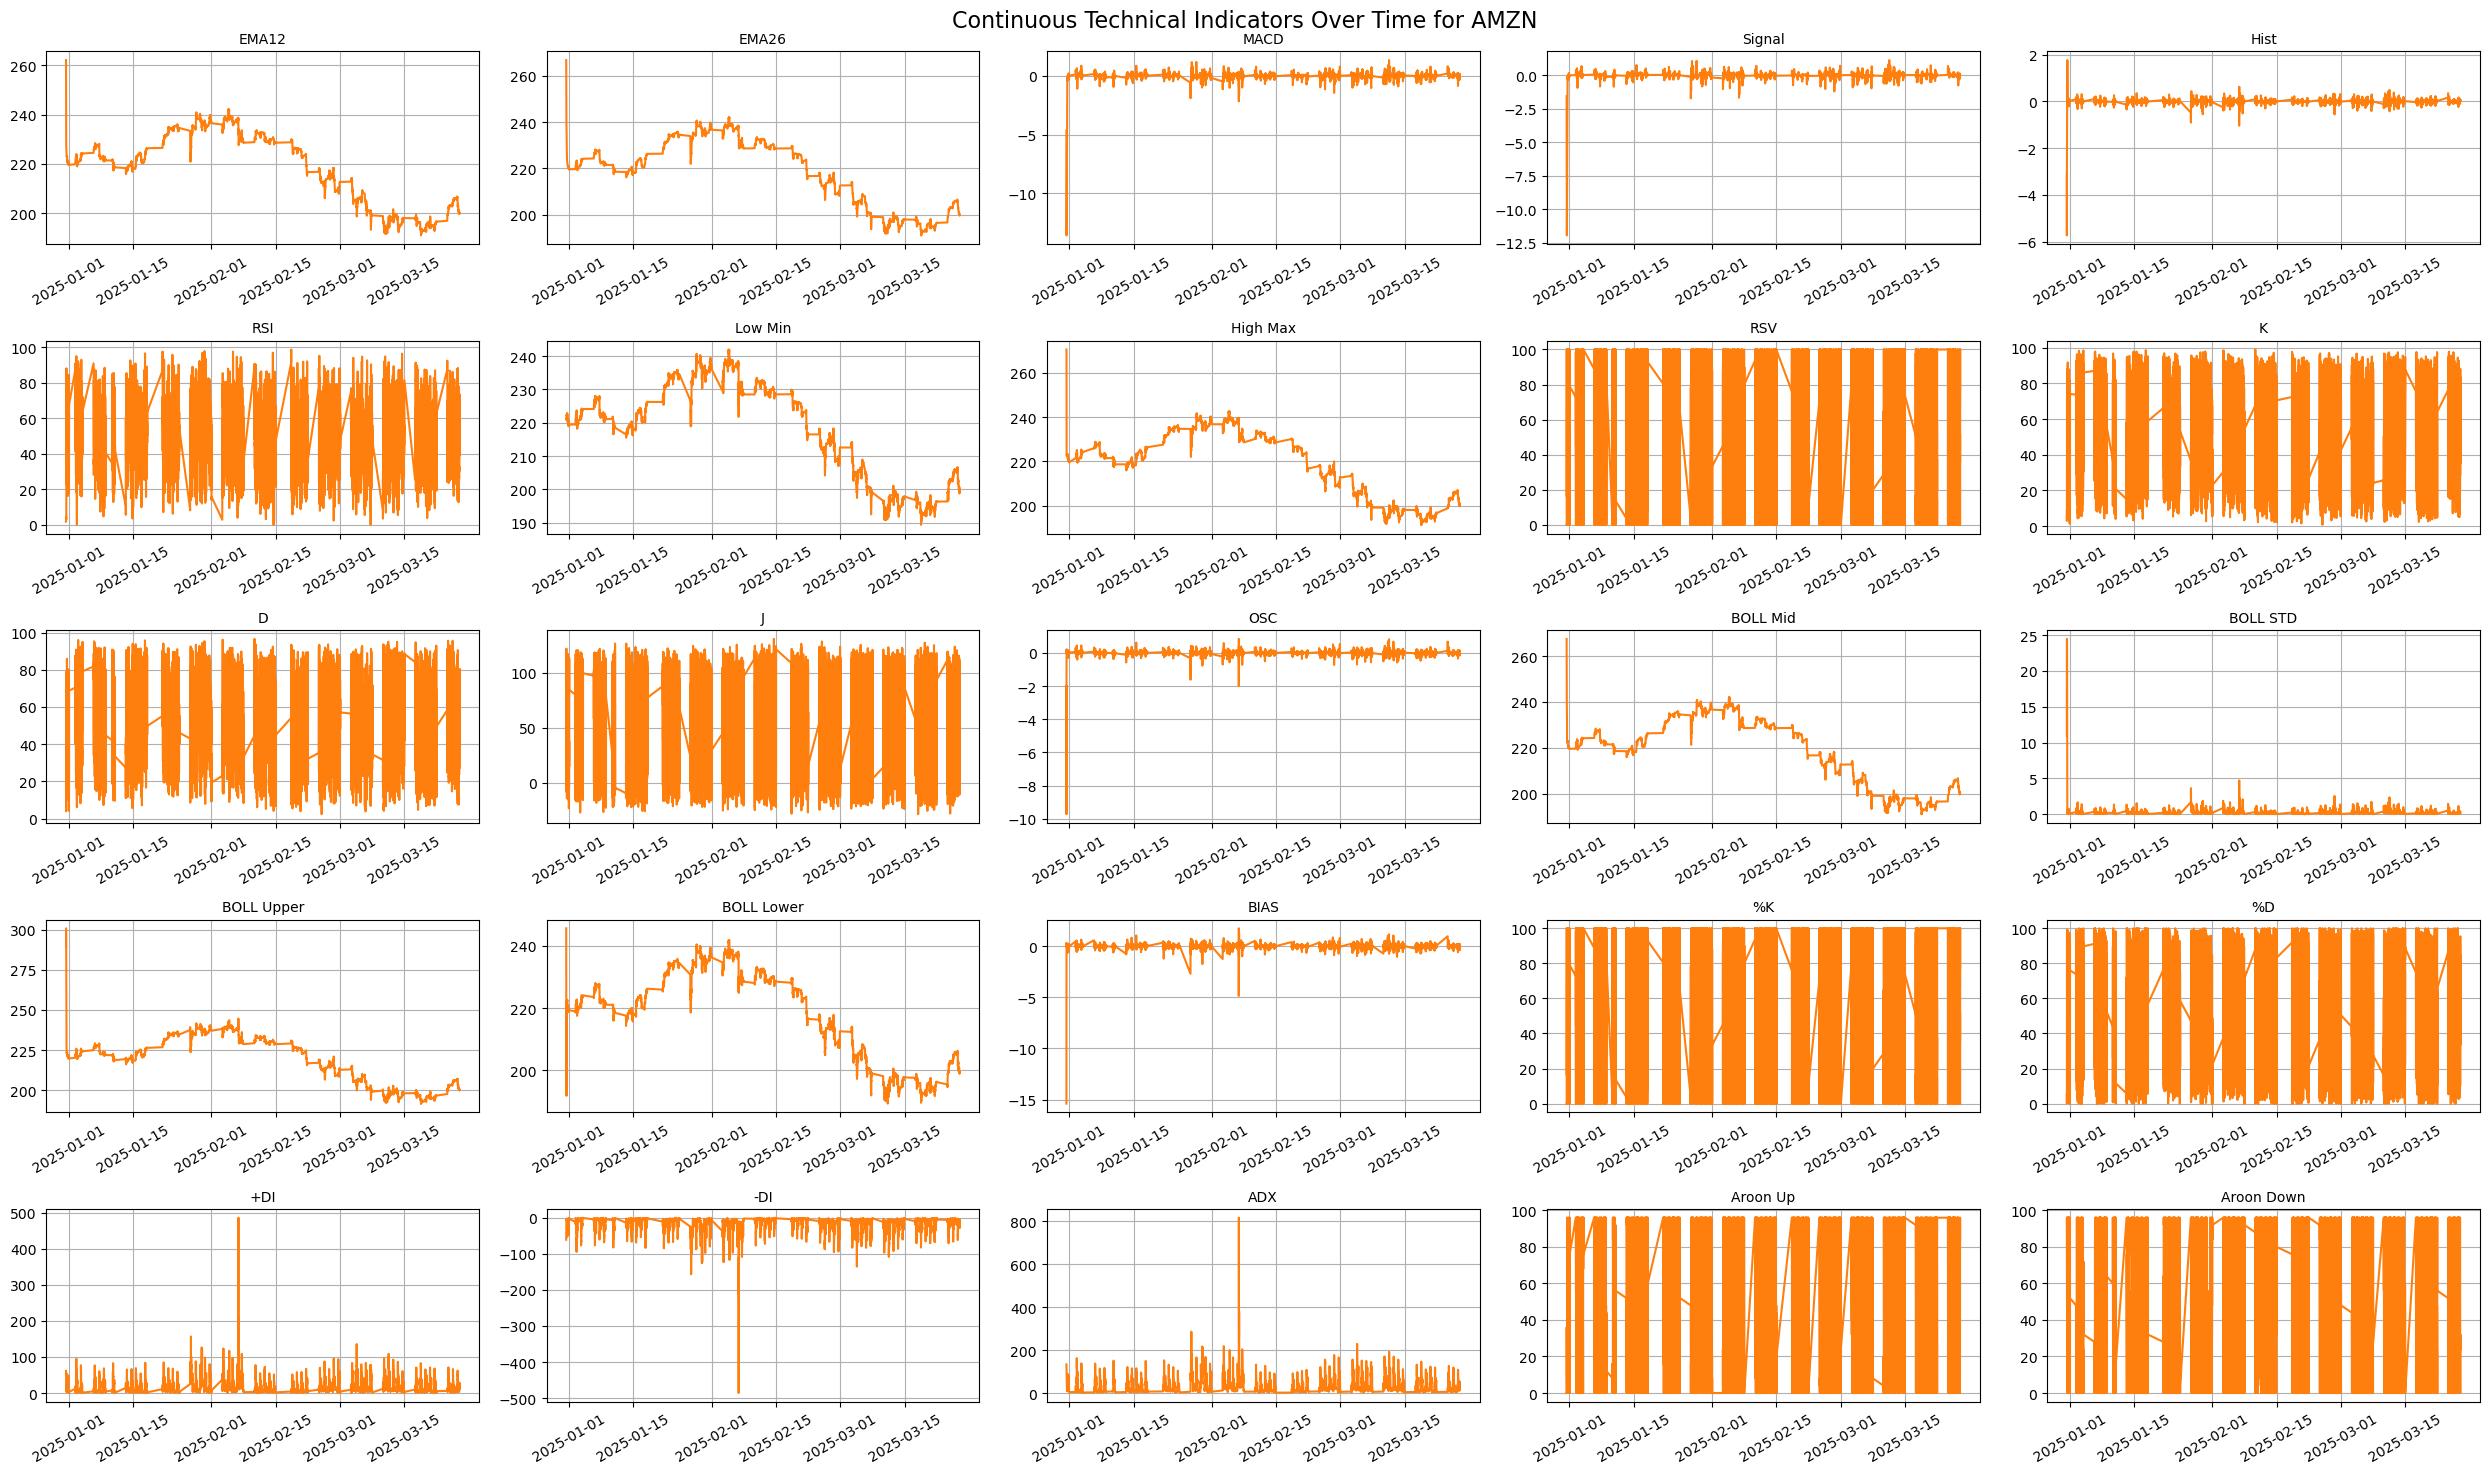

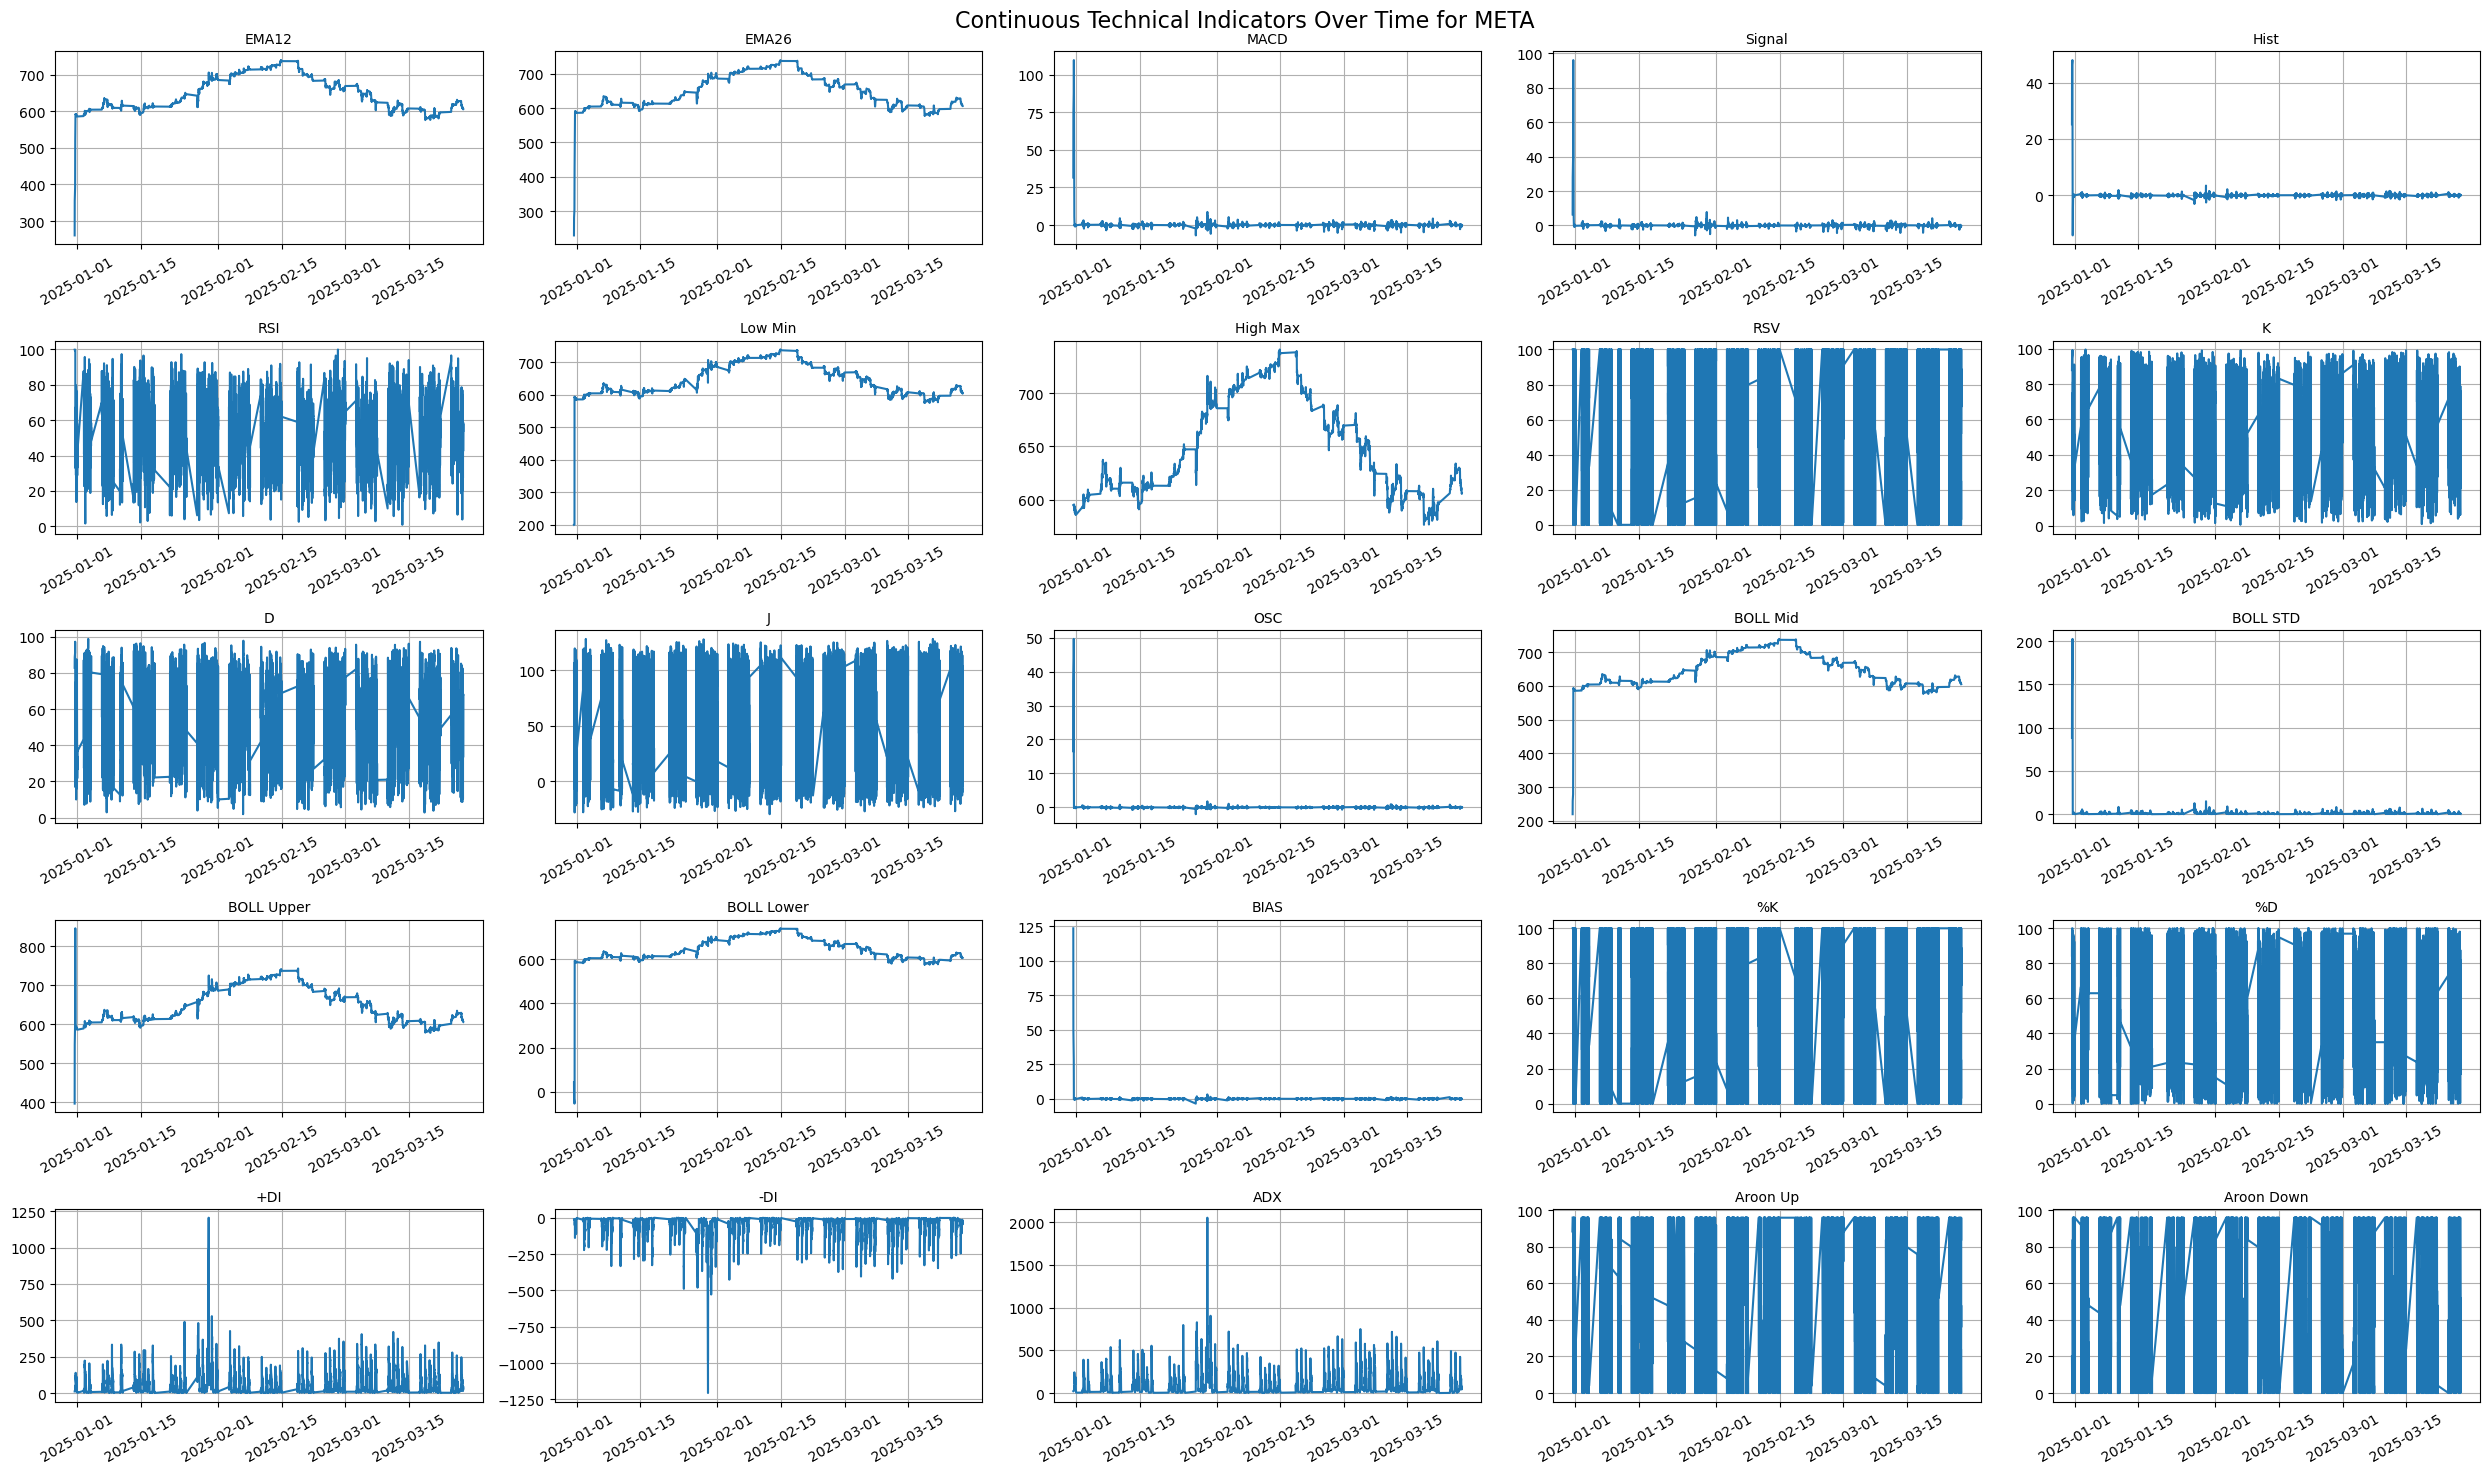

In [62]:
# Visualization of continuous technical indicators (excluding Buy/Sell binary columns) in a 5-column facet for each ticker
technical_columns = [col for col in df.columns if col not in ['Open', 'High', 'Low', 'Close', 'Volume', 'Ticker'] and 'Buy' not in col and 'Sell' not in col]
for stock, color in zip(stocks, colors):
    df_stock = df[df['Ticker'] == stock]
    n_cols = 5
    n_rows = (len(technical_columns) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, n_rows * 3))
    axes = axes.flatten()

    for i, col in enumerate(technical_columns):
        axes[i].plot(df_stock.index, df_stock[col], color=color)
        axes[i].set_title(col.replace('_', ' '), fontsize=10)
        axes[i].tick_params(axis='x', rotation=30)
        axes[i].grid(True)

    # Hide any empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(f'Continuous Technical Indicators Over Time for {stock}', fontsize=16)
    plt.tight_layout()
    plt.show()


In [63]:
# Add return target early for volatility plot
df['Return'] = df.groupby('Ticker')['Close'].pct_change().shift(-1)
df.dropna(subset=['Return'], inplace=True)

# Ensure Datetime is a column
df.reset_index(inplace=True)

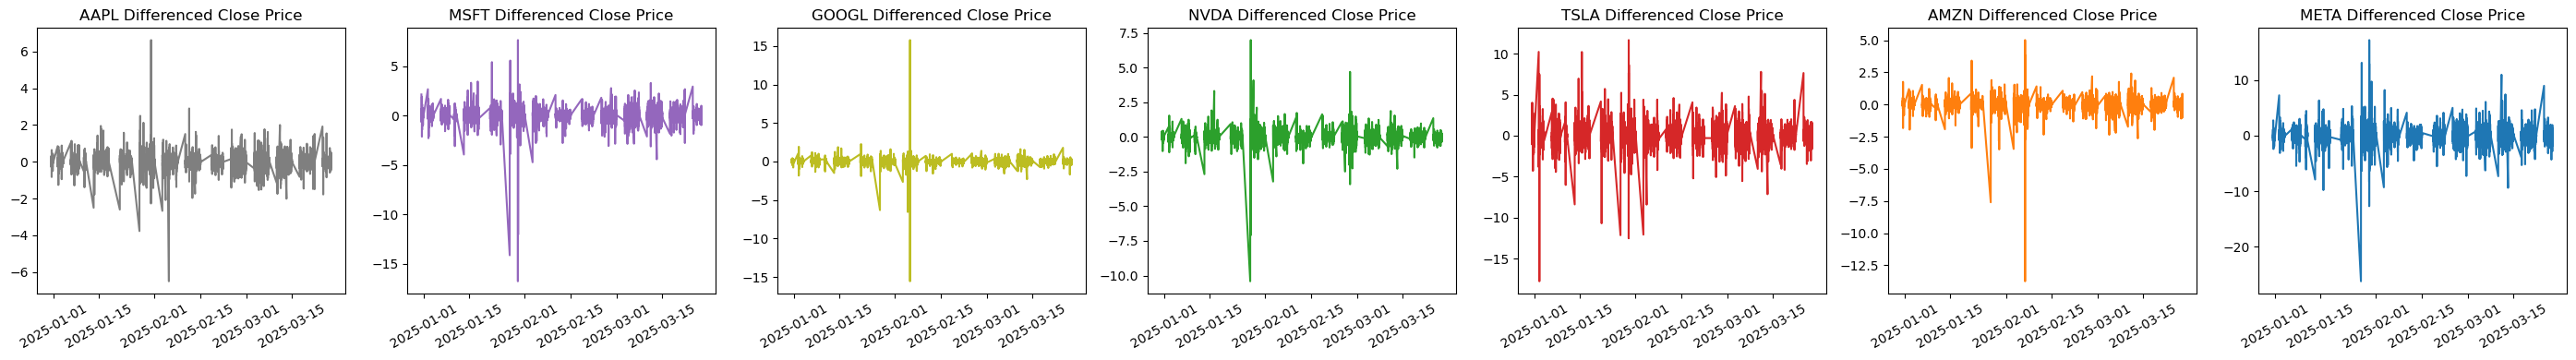

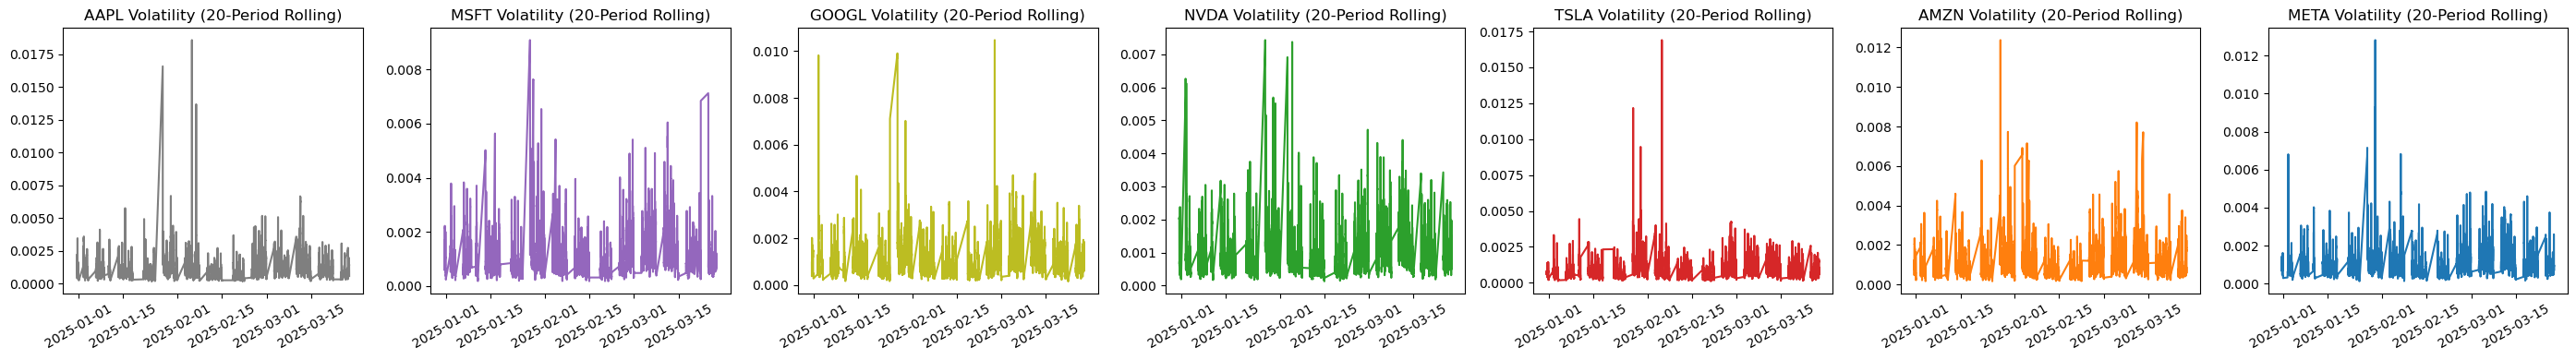

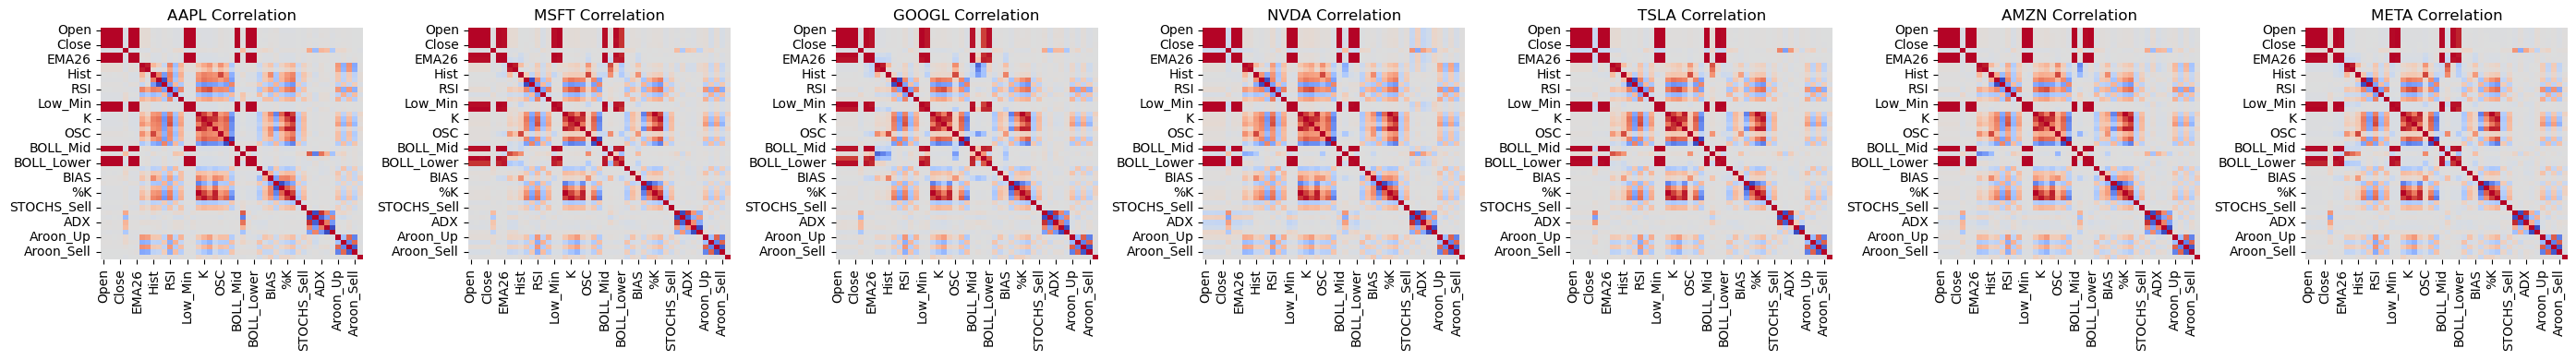

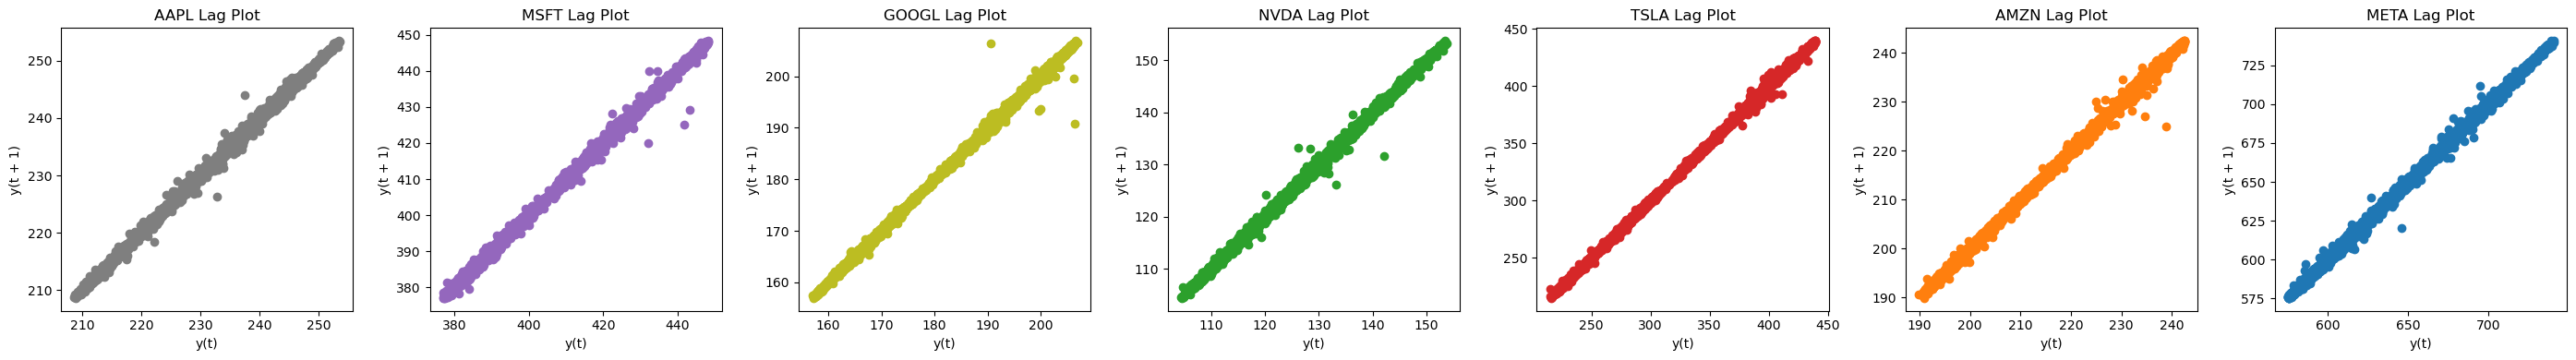

In [64]:
# Faceted plots for differenced close price, volatility, and rolling correlation
for metric_name, plot_func in [
    ("Differenced Close Price", lambda stock_df, ax, color: ax.plot(stock_df['Datetime'], stock_df['Close'].diff(), color=color)),
    ("Volatility (20-Period Rolling)", lambda stock_df, ax, color: ax.plot(stock_df['Datetime'], stock_df['Return'].rolling(window=20).std(), color=color)),
]:
    fig, axes = plt.subplots(1, 7, figsize=(28, 4))
    for ax, stock, color in zip(axes, stocks, colors):
        df_stock = df[df['Ticker'] == stock].copy()
        plot_func(df_stock, ax, color)
        ax.set_title(f'{stock} {metric_name}')
        ax.tick_params(axis='x', rotation=30)
    plt.tight_layout()
    plt.show()

# Faceted correlation heatmaps (7 columns)
fig, axes = plt.subplots(1, 7, figsize=(28, 4))
for ax, stock in zip(axes, stocks):
    df_stock = df[df['Ticker'] == stock]
    features_corr = df_stock.drop(columns=[col for col in ['Datetime', 'Ticker'] if col in df_stock.columns]).corr()
    sns.heatmap(features_corr, cmap='coolwarm', annot=False, cbar=False, ax=ax)
    ax.set_title(f'{stock} Correlation')
plt.tight_layout()
plt.show()

# Facet lag plots
fig, axes = plt.subplots(1, 7, figsize=(28, 4))
for ax, stock, color in zip(axes, stocks, colors):
    df_stock = df[df['Ticker'] == stock].copy()
    lag_plot(df_stock['Close'].dropna(), ax=ax, c=color)
    ax.set_title(f'{stock} Lag Plot')
plt.tight_layout()
plt.show()

In [65]:
# Load both sentiment files
sent1 = pd.read_csv('aggregated_daily_sentiment_1.csv')
sent2 = pd.read_csv('aggregated_daily_sentiment_2.csv')

# Combine them in order: part 1 comes before part 2
sentiment = pd.concat([sent1, sent2], ignore_index=True)

# Rename and parse dates
sentiment.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
sentiment['Date'] = pd.to_datetime(sentiment['Date'])

# Reshape to long format: Date | Ticker | Sentiment
sentiment = sentiment.melt(id_vars='Date', var_name='Ticker', value_name='Sentiment')
sentiment['Date'] = sentiment['Date'].dt.normalize()
sentiment['Date'] = sentiment['Date'].dt.tz_localize(None)

# Prepare stock data date column
df['Date'] = df['Datetime'].dt.normalize()
df['Date'] = df['Date'].dt.tz_localize(None)

# Merge daily sentiment into intraday stock data
df = pd.merge(df, sentiment, how='left', on=['Date', 'Ticker'])
df.drop(columns='Date', inplace=True)

# Fill any missing sentiment values with neutral (0)
df['Sentiment'] = df['Sentiment'].fillna(0)

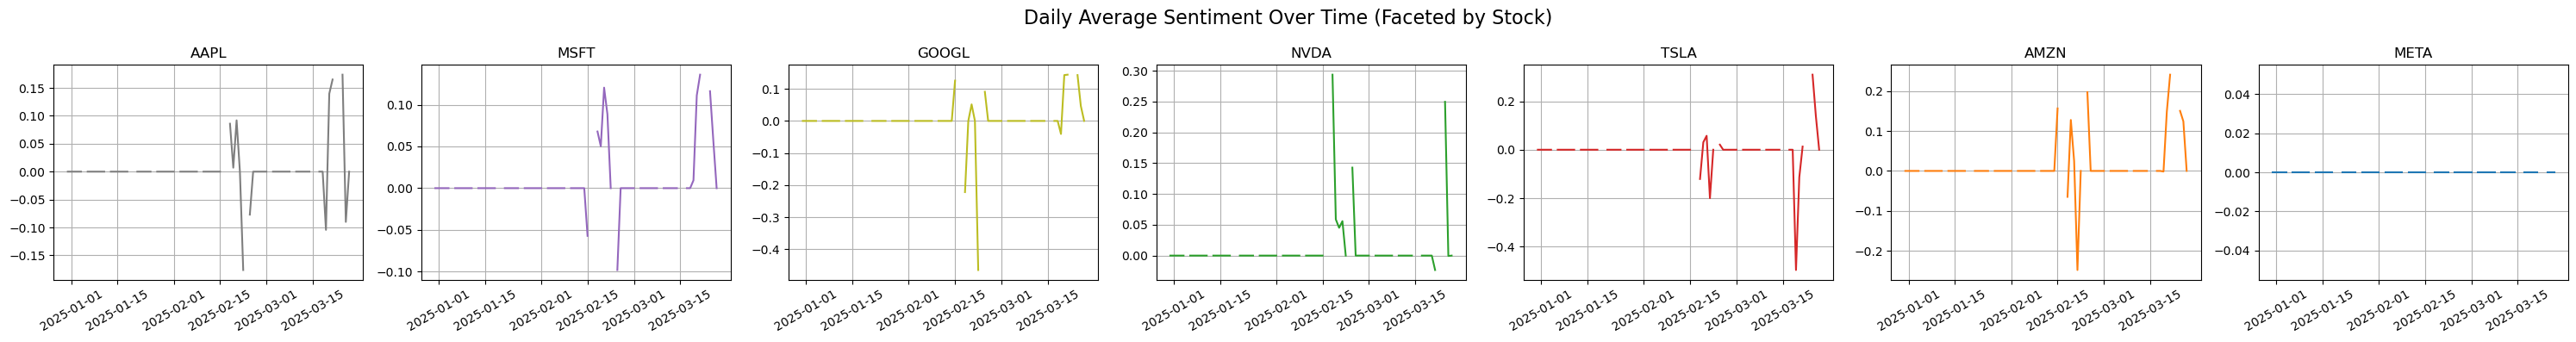

In [66]:
fig, axes = plt.subplots(1, 7, figsize=(30, 4))
for ax, ticker, color in zip(axes, stocks, colors):
    df_stock = df[df['Ticker'] == ticker]
    sentiment_daily = df_stock.resample('1D', on='Datetime')['Sentiment'].mean()

    ax.plot(sentiment_daily.index, sentiment_daily.values, color=color, label='Sentiment')
    ax.set_title(ticker)
    ax.grid(True)
    ax.tick_params(axis='x', rotation=30)

plt.suptitle('Daily Average Sentiment Over Time (Faceted by Stock)', fontsize=16)
plt.tight_layout()
plt.show()


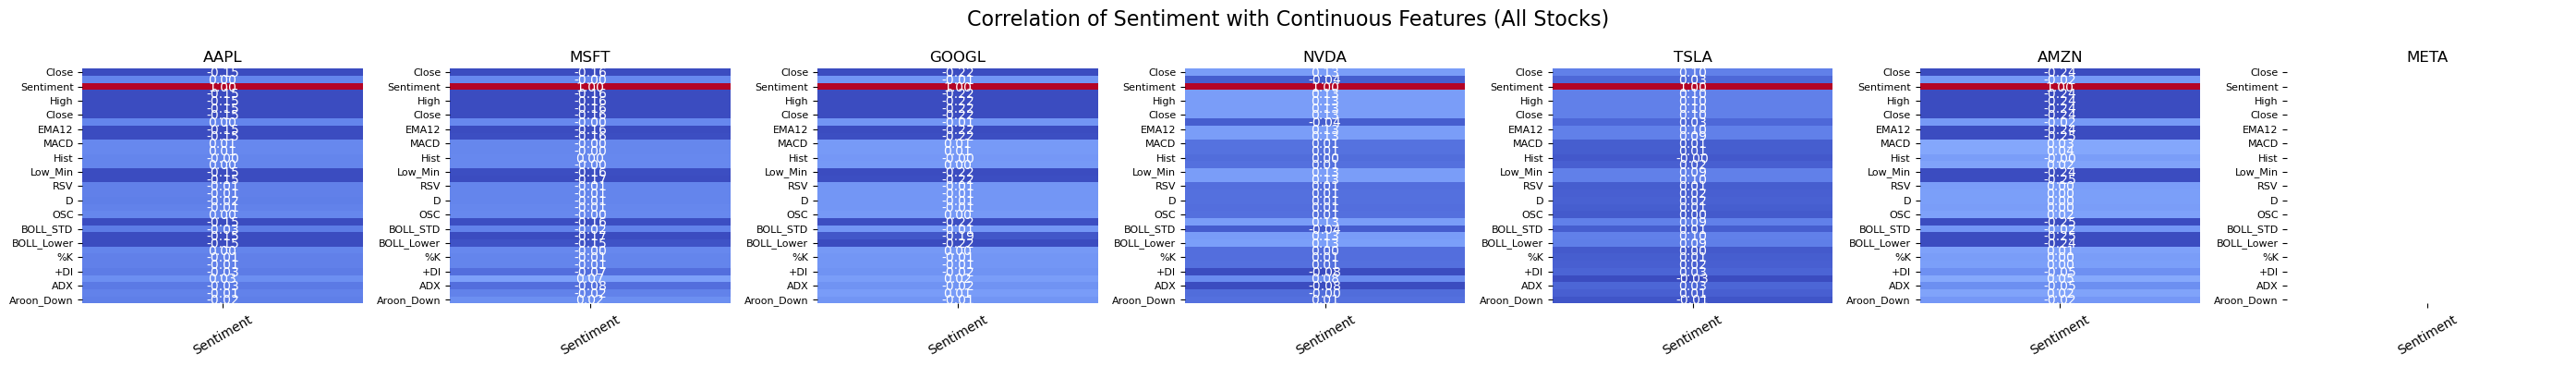

In [67]:
fig, axes = plt.subplots(1, 7, figsize=(28, 4))

for ax, ticker in zip(axes, stocks):
    df_stock = df[df['Ticker'] == ticker].copy()

    # Filter only continuous features + sentiment
    continuous_cols = ['Close', 'Volume', 'Sentiment'] + [
        col for col in df.columns
        if col not in ['Datetime', 'Ticker', 'Sentiment', 'Return']
        and not col.endswith('_Buy')
        and not col.endswith('_Sell')
    ]
    df_corr = df_stock[continuous_cols].dropna()

    corr_matrix = df_corr.corr()

    # Plot only the sentiment column correlation
    sns.heatmap(
        corr_matrix[['Sentiment']],
        ax=ax,
        annot=True,
        cmap='coolwarm',
        fmt=".2f",
        cbar=False
    )
    ax.set_title(ticker)
    ax.tick_params(axis='x', rotation=30)
    ax.tick_params(axis='y', labelsize=8)

plt.suptitle('Correlation of Sentiment with Continuous Features (All Stocks)', fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
#Hyperparameter Tuning 
# Add return target for modeling and volatility plots
df['Return'] = df.groupby('Ticker')['Close'].pct_change().shift(-1)
df.dropna(subset=['Return'], inplace=True)

# Ensure correct datetime and indexing
df = df.sort_values(['Ticker', 'Datetime']).reset_index(drop=True)

# Prepare sequences for LSTM training
def prepare_sequences(df, feature_cols, sequence_length=20):
    feature_scaler = RobustScaler()
    return_scaler = RobustScaler()

    X_scaled = feature_scaler.fit_transform(df[feature_cols])
    y_scaled = return_scaler.fit_transform(df[['Return']])

    X_sequences, y_sequences, dates, close_prices = [], [], df['Datetime'].values[sequence_length:], df['Close'].values[sequence_length:]

    for i in range(len(X_scaled) - sequence_length):
        X_sequences.append(X_scaled[i:i+sequence_length])
        y_sequences.append(y_scaled[i+sequence_length])

    return np.array(X_sequences), np.array(y_sequences), dates, close_prices, return_scaler

def build_lstm_model(input_shape, dropout_rate=0.3, learning_rate=0.001):

    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape),
        Dropout(dropout_rate),

        Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape),
        Dropout(dropout_rate), 

        LSTM(32),
        Dropout(dropout_rate),

        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation='tanh')
    ])
    
    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['mae']
    )
    
    return model


def train_and_evaluate(df, feature_cols, ticker):
    """
    Trains and evaluates the model for a specific stock ticker using hyperparameter optimization.

    Parameters:
    df (DataFrame): The dataset containing stock data
    feature_cols (list): List of feature column names
    ticker (str): The ticker symbol for the stock being evaluated

    Returns:
    trades (DataFrame): DataFrame with trading strategy results
    """
    df_ticker = df[df['Ticker'] == ticker].copy()
    df_ticker = df_ticker.sort_values('Datetime').reset_index(drop=True)

    # Split data based on date
    train_data = df_ticker[df_ticker['Datetime'] < '2025-03-01']
    test_data = df_ticker[df_ticker['Datetime'] >= '2025-03-01']

    # Prepare sequences
    X_train, y_train, _, _, return_scaler = prepare_sequences(train_data, feature_cols)
    X_test, y_test, dates_test, close_prices_test, _ = prepare_sequences(test_data, feature_cols)

    global num_features
    num_features = X_train.shape[2]

    # Define the KerasRegressor with the build function
    keras_model = KerasRegressor(model=build_lstm_model, model__input_shape=(X_train.shape[1], num_features), epochs=30, verbose=0)

    # Randomized Search Parameter Grid
    param_dist = {
        "model__dropout_rate": [0.2, 0.3],  # Randomly choose from 0.2 to 0.5
        "model__learning_rate": [0.001, 0.0005, 0.0003],  # Trial different learning rates
        "batch_size": [16, 32, 64]  # Different batch sizes
    }

    # Callbacks for early stopping and learning rate reduction
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    ]

    # RandomizedSearchCV for hyperparameter optimization
    search = RandomizedSearchCV(
        estimator=keras_model,
        param_distributions=param_dist,
        n_iter=3,  # Number of random combinations to try
        cv=2,  # 2-fold cross-validation
        verbose=1,
        n_jobs=1
    )

    #search.fit(X_train, y_train, callbacks=callbacks)
    #print(f"Best params for {ticker}:", search.best_params_)

    # Get the best model from the search
    best_model = search.best_estimator_.model_

    # Predictions
    y_pred_scaled = best_model.predict(X_test)
    y_pred = return_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    y_test_actual = return_scaler.inverse_transform(y_test.reshape(-1, 1))

    # Trading logic (no trading fees)
    positions = np.where(y_pred.flatten() > 0, 'LONG', 'SHORT')
    strategy_returns = np.zeros_like(y_test_actual.flatten())

    for i in range(len(y_test_actual)):
        curr_position = positions[i]
        if curr_position == 'LONG':
            ret = y_test_actual[i]
        elif curr_position == 'SHORT':
            ret = -y_test_actual[i]
        else:
            ret = 0
        strategy_returns[i] = ret

    cumulative_return = np.cumprod(1 + strategy_returns)

    trades = pd.DataFrame({
        'Date': dates_test,
        'Close_Price': close_prices_test,
        'Actual_Return': y_test_actual.flatten(),
        'Predicted_Return': y_pred.flatten(),
        'Position': positions,
        'Strategy_Return': strategy_returns,
        'Cumulative_Return': cumulative_return,
        'Ticker': ticker
    })

    return trades

feature_cols = ['Close', 'MACD_Buy', 'MACD_Sell', 'RSI_Buy', 'RSI_Sell', 'STOCHS_Buy', 'STOCHS_Sell',
                'ADX_Buy', 'ADX_Sell', 'Aroon_Buy', 'Aroon_Sell', 'BOLL_Buy', 'BOLL_Sell', 'OSC_Buy', 'OSC_Sell', 'BIAS_Buy', 'BIAS_Sell',
                'Sentiment']

# Train models and compile trades
all_trades = []
for ticker in stocks:
    print(f"Training model for {ticker}...")
    trades = train_and_evaluate(df, feature_cols, ticker)
    all_trades.append(trades)

all_trades_df = pd.concat(all_trades, ignore_index=True) 



Training model for AAPL...
Fitting 2 folds for each of 3 candidates, totalling 6 fits
Best params for AAPL: {'model__learning_rate': 0.0003, 'model__dropout_rate': 0.3, 'batch_size': 16}
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Training model for MSFT...
Fitting 2 folds for each of 3 candidates, totalling 6 fits
Best params for MSFT: {'model__learning_rate': 0.001, 'model__dropout_rate': 0.2, 'batch_size': 64}
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Training model for GOOGL...
Fitting 2 folds for each of 3 candidates, totalling 6 fits
Best params for GOOGL: {'model__learning_rate': 0.0003, 'model__dropout_rate': 0.3, 'batch_size': 64}
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Training model for NVDA...
Fitting 2 folds for each of 3 candidates, totalling 6 fits
Best params for NVDA: {'model__learning_rate': 0.001, 'model__dropout_rate': 0.3, 'batch_size': 16}
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Training model for TSLA...
Fitting 2 folds for each of 3 candidates, totalling 6 fits
Be

In [68]:
#Hyperparameter Tuning 
# Add return target for modeling and volatility plots
df['Return'] = df.groupby('Ticker')['Close'].pct_change().shift(-1)
df.dropna(subset=['Return'], inplace=True)

# Ensure correct datetime and indexing
df = df.sort_values(['Ticker', 'Datetime']).reset_index(drop=True)

# Prepare sequences for LSTM training
def prepare_sequences(df, feature_cols, sequence_length=20):
    feature_scaler = RobustScaler()
    return_scaler = RobustScaler()

    X_scaled = feature_scaler.fit_transform(df[feature_cols])
    y_scaled = return_scaler.fit_transform(df[['Return']])

    X_sequences, y_sequences, dates, close_prices = [], [], df['Datetime'].values[sequence_length:], df['Close'].values[sequence_length:]

    for i in range(len(X_scaled) - sequence_length):
        X_sequences.append(X_scaled[i:i+sequence_length])
        y_sequences.append(y_scaled[i+sequence_length])

    return np.array(X_sequences), np.array(y_sequences), dates, close_prices, return_scaler
def build_lstm_model(input_shape, dropout_rate=0.3, learning_rate=0.0003):
    """
    Builds and compiles the LSTM model with given parameters.
    Parameters:
    input_shape (tuple): Shape of the input data (sequence_length, num_features)
    dropout_rate (float): Dropout rate for regularization
    learning_rate (float): Learning rate for the Adam optimizer
    Returns:
    model (Keras Model): Compiled LSTM model
    """
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape),
        Dropout(dropout_rate),

        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(dropout_rate), 

        LSTM(32),
        Dropout(dropout_rate),

        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation='tanh')
    ])
    
    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['mae']
    )
    
    return model


def train_and_evaluate(df, feature_cols, ticker):
    """
    Trains and evaluates the model for a specific stock ticker using fixed hyperparameters.
    Parameters:
    df (DataFrame): The dataset containing stock data
    feature_cols (list): List of feature column names
    ticker (str): The ticker symbol for the stock being evaluated
    Returns:
    trades (DataFrame): DataFrame with trading strategy results
    """
    df_ticker = df[df['Ticker'] == ticker].copy()
    df_ticker = df_ticker.sort_values('Datetime').reset_index(drop=True)

    # Split data based on date
    train_data = df_ticker[df_ticker['Datetime'] < '2025-03-01']
    test_data = df_ticker[df_ticker['Datetime'] >= '2025-03-01']

    # Prepare sequences
    X_train, y_train, _, _, return_scaler = prepare_sequences(train_data, feature_cols)
    X_test, y_test, dates_test, close_prices_test, _ = prepare_sequences(test_data, feature_cols)

    global num_features
    num_features = X_train.shape[2]

    # Initialize the KerasRegressor with fixed hyperparameters
    keras_model = KerasRegressor(model=build_lstm_model, model__input_shape=(X_train.shape[1], num_features), 
                                 epochs=30, batch_size=64, verbose=0)

    # Define the fixed callbacks for early stopping and learning rate reduction
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    ]

    # Fit the model (searching for the best parameters is now removed)
    keras_model.fit(X_train, y_train, callbacks=callbacks)

    # Predictions
    y_pred_scaled = keras_model.predict(X_test)
    y_pred = return_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    y_test_actual = return_scaler.inverse_transform(y_test.reshape(-1, 1))

    # Trading logic (no trading fees)
    positions = np.where(y_pred.flatten() > 0, 'LONG', 'SHORT')
    strategy_returns = np.zeros_like(y_test_actual.flatten())

    for i in range(len(y_test_actual)):
        curr_position = positions[i]
        if curr_position == 'LONG':
            ret = y_test_actual[i]
        elif curr_position == 'SHORT':
            ret = -y_test_actual[i]
        else:
            ret = 0
        strategy_returns[i] = ret

    cumulative_return = np.cumprod(1 + strategy_returns)

    trades = pd.DataFrame({
        'Date': dates_test,
        'Close_Price': close_prices_test,
        'Actual_Return': y_test_actual.flatten(),
        'Predicted_Return': y_pred.flatten(),
        'Position': positions,
        'Strategy_Return': strategy_returns,
        'Cumulative_Return': cumulative_return,
        'Ticker': ticker
    })

    return trades

# Fixed parameters
feature_cols = ['Close', 'MACD_Buy', 'MACD_Sell', 'RSI_Buy', 'RSI_Sell', 'STOCHS_Buy', 'STOCHS_Sell',
                'ADX_Buy', 'ADX_Sell', 'Aroon_Buy', 'Aroon_Sell', 'BOLL_Buy', 'BOLL_Sell', 'OSC_Buy', 'OSC_Sell', 'BIAS_Buy', 'BIAS_Sell',
                'Sentiment']

# Train models and compile trades
all_trades = []
for ticker in stocks:
    print(f"Training model for {ticker}...")
    trades = train_and_evaluate(df, feature_cols, ticker)
    all_trades.append(trades)

all_trades_df = pd.concat(all_trades, ignore_index=True)


Training model for AAPL...
Training model for MSFT...
Training model for GOOGL...
Training model for NVDA...
Training model for TSLA...
Training model for AMZN...
Training model for META...


In [ ]:
# Sensitivity analysis function
def run_sensitivity_analysis(df):
    """
    Perform sensitivity analysis by adjusting the predicted returns and evaluating final cumulative return.
    """
    sensitivity_factors = [0.9, 1.1, 0.8, 1.2, 0.5, 1.5]
    results = []

    for factor in sensitivity_factors:
        df_temp = df.copy()
        df_temp['Adj_Predicted_Return'] = df_temp['Predicted_Return'] * factor

        positions = np.where(df_temp['Adj_Predicted_Return'] > 0, 'LONG', 'SHORT')
        strategy_returns = np.zeros_like(df_temp['Actual_Return'])

        for i in range(len(df_temp)):
            curr_position = positions[i]
            actual_ret = df_temp.loc[i, 'Actual_Return']

            if curr_position == 'LONG':
                ret = actual_ret
            elif curr_position == 'SHORT':
                ret = -actual_ret
            else:
                ret = 0

            strategy_returns[i] = ret

        cumulative_return = np.cumprod(1 + strategy_returns)[-1]
        results.append((factor, cumulative_return))

    df_sensitivity = pd.DataFrame(results, columns=["Adjustment_Factor", "Final_Cumulative_Return"])
    return df_sensitivity

# Stress testing function
def run_stress_testing(df):
    """
    Perform stress tests by simulating various market shock scenarios.
    """
    scenarios = {
        'Crash': df['Actual_Return'] - 0.05,  # simulate 5% market crash
        'Volatility_Spike': df['Actual_Return'] + np.random.normal(0, 0.02, size=len(df)),
        'Prediction_Inverted': -df['Predicted_Return'],
        'Zero_Prediction': np.zeros_like(df['Predicted_Return'])
    }

    results = []
    for scenario_name, shock in scenarios.items():
        df_temp = df.copy()

        if 'Prediction' in scenario_name:
            df_temp['Adj_Predicted_Return'] = shock
        else:
            df_temp['Adj_Predicted_Return'] = df_temp['Predicted_Return']
            df_temp['Actual_Return'] = shock

        positions = np.where(df_temp['Adj_Predicted_Return'] > 0, 'LONG', 'SHORT')
        strategy_returns = np.zeros_like(df_temp['Actual_Return'])

        for i in range(len(df_temp)):
            curr_position = positions[i]
            actual_ret = df_temp.loc[i, 'Actual_Return']

            if curr_position == 'LONG':
                ret = actual_ret
            elif curr_position == 'SHORT':
                ret = -actual_ret
            else:
                ret = 0

            strategy_returns[i] = ret

        cumulative_return = np.cumprod(1 + strategy_returns)[-1]
        results.append((scenario_name, cumulative_return))

    df_stress = pd.DataFrame(results, columns=["Scenario", "Final_Cumulative_Return"])
    return df_stress

NameError: name 'dates_test' is not defined

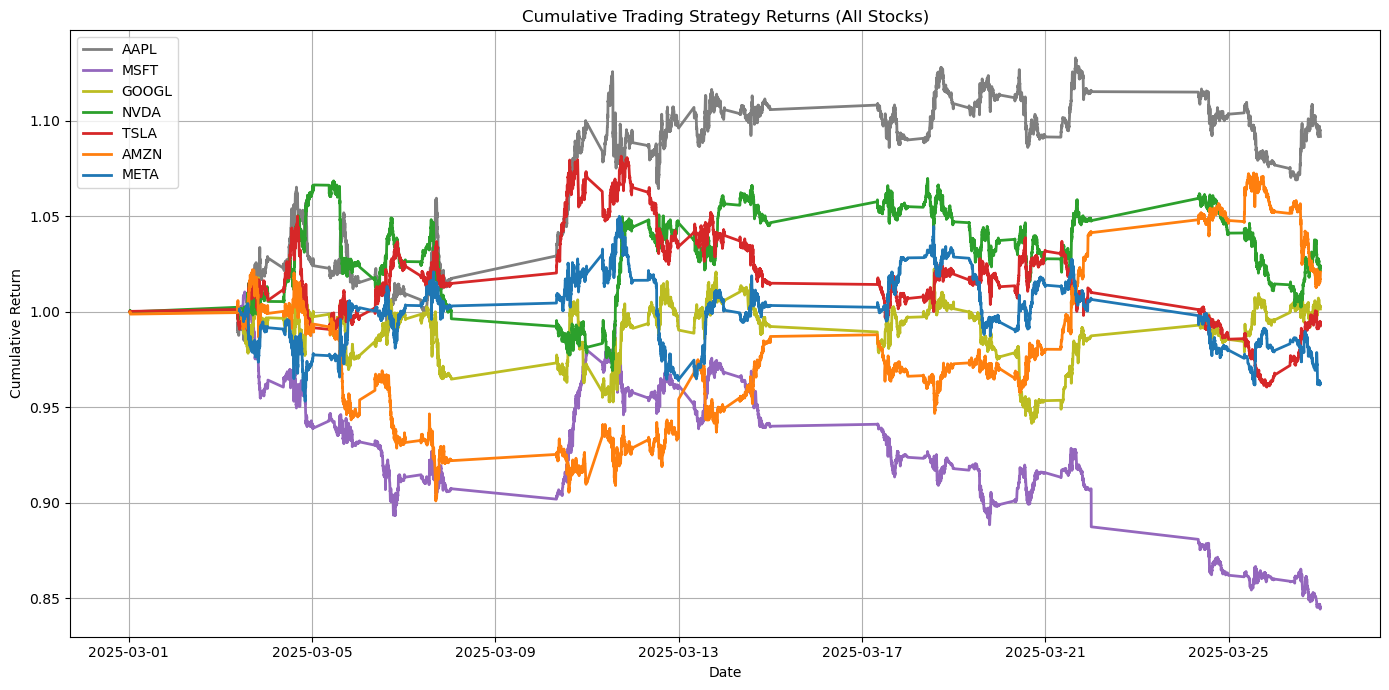

In [69]:
# Add rolling metrics
all_trades_df['Rolling_Risk'] = all_trades_df.groupby('Ticker')['Actual_Return'].transform(lambda x: x.rolling(window=10).std())
all_trades_df['Rolling_Average'] = all_trades_df.groupby('Ticker')['Actual_Return'].transform(lambda x: x.rolling(window=10).mean())

# Improved Trading Strategy Plot with consistent x-axis and grid
def plot_trading_strategy(all_trades_df):
    plt.figure(figsize=(14, 7))
    for ticker, color in zip(stocks, colors):
        ticker_data = all_trades_df[all_trades_df['Ticker'] == ticker]
        plt.plot(pd.to_datetime(ticker_data['Date']), ticker_data['Cumulative_Return'], label=ticker, color=color, linewidth=2)
    plt.title('Cumulative Trading Strategy Returns (All Stocks)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_trading_strategy(all_trades_df)

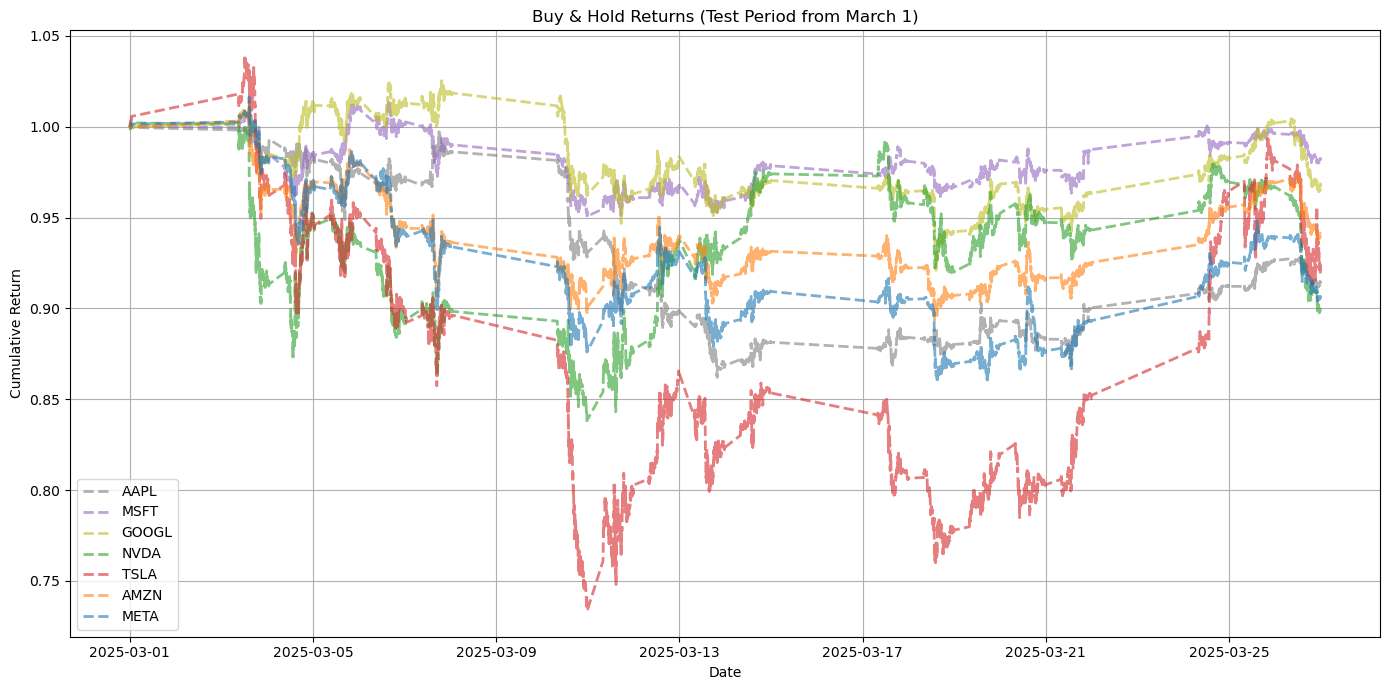

In [70]:
# Improved Buy & Hold Plot with consistent datetime parsing
import matplotlib.colors as mcolors

def plot_buy_and_hold_test_period(df):
    plt.figure(figsize=(14, 7))
    for ticker, color in zip(stocks, colors):
        df_ticker = df[df['Ticker'] == ticker].sort_values('Datetime')
        df_test = df_ticker[df_ticker['Datetime'] >= '2025-03-01']

        if df_test.empty:
            continue

        buy_hold_returns = df_test['Close'] / df_test['Close'].iloc[0]
        # Use darker version of the color
        darker_color = mcolors.to_rgba(color, alpha=0.6)
        plt.plot(df_test['Datetime'], buy_hold_returns, label=f'{ticker}', color=darker_color, linestyle='--', linewidth=2)

    plt.title('Buy & Hold Returns (Test Period from March 1)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_buy_and_hold_test_period(df)

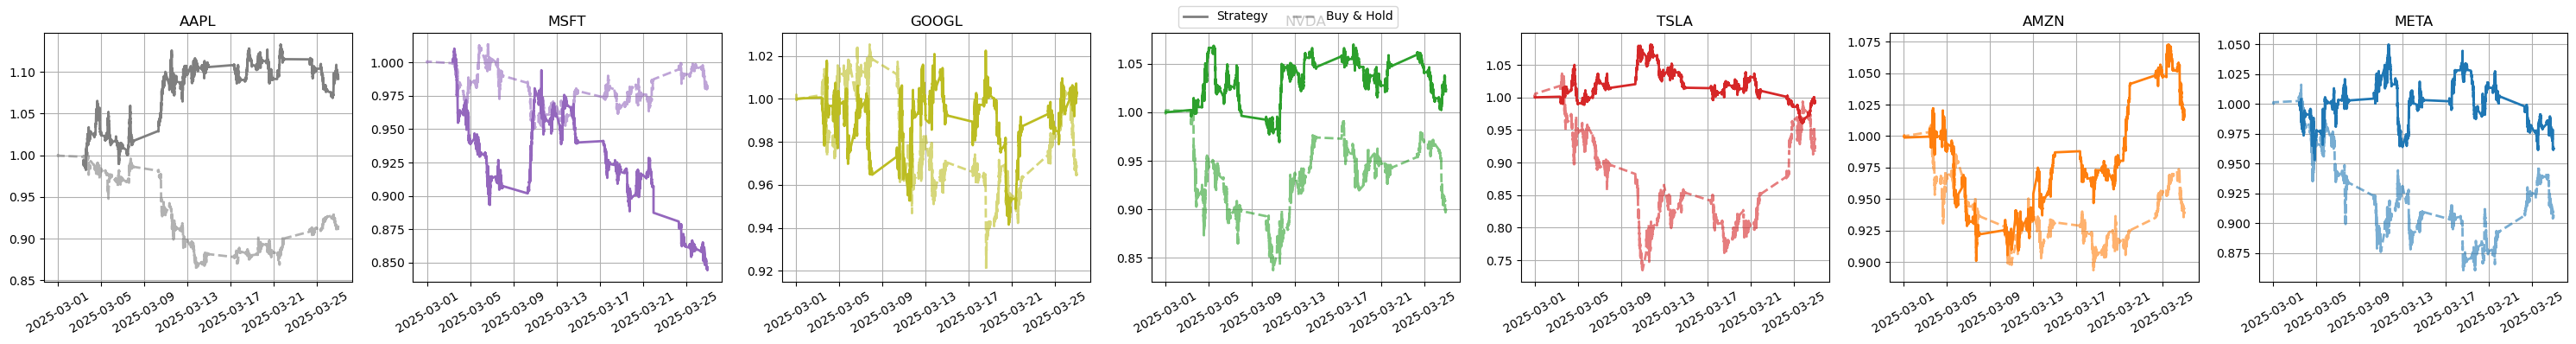

In [71]:
def plot_trading_vs_buy_hold(df, all_trades_df):
    fig, axes = plt.subplots(1, 7, figsize=(30, 4))
    for ax, ticker, color in zip(axes, stocks, colors):
        trades = all_trades_df[all_trades_df['Ticker'] == ticker]
        df_ticker = df[df['Ticker'] == ticker].sort_values('Datetime')
        df_test = df_ticker[df_ticker['Datetime'] >= '2025-03-01']

        if df_test.empty or trades.empty:
            continue

        buy_hold_returns = df_test['Close'] / df_test['Close'].iloc[0]
        darker_color = mcolors.to_rgba(color, alpha=0.6)

        ax.plot(pd.to_datetime(trades['Date']), trades['Cumulative_Return'], color=color, label='Strategy', linewidth=2)
        ax.plot(df_test['Datetime'], buy_hold_returns, color=darker_color, linestyle='--', label='Buy & Hold', linewidth=2)

        ax.set_title(f'{ticker}')
        ax.grid(True)
        ax.tick_params(axis='x', rotation=30)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=2, frameon=True, fontsize=10)
    plt.tight_layout()
    plt.show()


plot_trading_vs_buy_hold(df, all_trades_df)

In [72]:
# Compare final returns
def calculate_strategy_returns(df, all_trades_df):
    results = []
    for ticker in df['Ticker'].unique():
        df_ticker = df[df['Ticker'] == ticker].sort_values('Datetime')
        df_test = df_ticker[df_ticker['Datetime'] >= '2025-03-01']

        if df_test.empty:
            continue

        buy_and_hold_return = (df_test['Close'].iloc[-1] / df_test['Close'].iloc[0]) - 1

        df_trades = all_trades_df[all_trades_df['Ticker'] == ticker]
        strategy_return = df_trades['Cumulative_Return'].iloc[-1] - 1 if not df_trades.empty else None

        results.append({
            "Ticker": ticker,
            "Buy & Hold Return (%)": round(buy_and_hold_return * 100, 2),
            "Trading Strategy Return (%)": round(strategy_return * 100, 2) if strategy_return is not None else None
        })

    return pd.DataFrame(results)

strategy_returns_df = calculate_strategy_returns(df, all_trades_df)
print(strategy_returns_df)

  Ticker  Buy & Hold Return (%)  Trading Strategy Return (%)
0   AAPL                  -8.46                         9.19
1   AMZN                  -5.83                         2.08
2  GOOGL                  -3.08                         0.15
3   META                  -9.37                        -3.74
4   MSFT                  -1.82                       -15.49
5   NVDA                 -10.04                         2.18
6   TSLA                  -8.31                        -0.57


In [ ]:
all_trades_df.head(5)

Date  Close_Price  Actual_Return  Predicted_Return Position  \
0 2025-03-03 09:00:00       241.55       0.009173          0.000024     LONG   
1 2025-03-03 09:02:00       241.50      -0.001372          0.000022     LONG   
2 2025-03-03 09:04:00       241.62       0.000155          0.000026     LONG   
3 2025-03-03 09:06:00       241.67      -0.001933          0.000030     LONG   
4 2025-03-03 09:08:00       241.48      -0.000492          0.000029     LONG   

   Cumulative_Return Ticker  Rolling_Risk  Rolling_Average  
0           1.009173   AAPL           NaN              NaN  
1           1.007789   AAPL           NaN              NaN  
2           1.007945   AAPL           NaN              NaN  
3           1.005997   AAPL           NaN              NaN  
4           1.005502   AAPL           NaN              NaN

In [ ]:
all_trades_df.tail(5)

Date  Close_Price  Actual_Return  Predicted_Return  \
53262 2025-03-26 23:44:00     605.2400      -0.001341          0.000005   
53263 2025-03-26 23:46:00     605.5000      -0.000229          0.000027   
53264 2025-03-26 23:52:00     606.0000       0.000795          0.000024   
53265 2025-03-26 23:54:00     605.5101      -0.000292          0.000034   
53266 2025-03-26 23:56:00     605.8000       0.000005          0.000022   

      Position  Cumulative_Return Ticker  Rolling_Risk  Rolling_Average  
53262     LONG           1.183912   META      0.000973        -0.000227  
53263     LONG           1.183641   META      0.000971        -0.000212  
53264     LONG           1.184583   META      0.000979        -0.000036  
53265     LONG           1.184237   META      0.000957         0.000004  
53266     LONG           1.184243   META      0.000810         0.000150

In [ ]:
all_trades_df.to_csv("returns.csv")